
# Wildfire Smoke PM2.5 Modeling with Convex Optimization and Low-Cost Sensors

**Author:** Param Somane  
**Date:** 2025-02-09  

---

## Table of Contents

1. [Introduction and Motivation](#introduction)  
2. [Practical and Theoretical Background](#background)  
   - [2.1 Convex Optimization in Environmental Monitoring](#convex-optim)  
   - [2.2 Graph-Based Signal Processing](#graph-signal)  
   - [2.3 Total Variation Minimization](#tv-min)  
   - [2.4 Kriging as a Baseline](#kriging-baseline)  
3. [Data Overview and Preprocessing](#data-overview)  
   - [3.1 Directory Structure and Relevant CSVs](#directory-structure)  
   - [3.2 Scanning and Harmonizing Column Names](#scan-columns)  
   - [3.3 Data Loading with Dynamic Column Mapping](#loader-code)  
4. [Methods](#methods)  
   - [4.1 Building a Sensor Graph](#sensor-graph)  
   - [4.2 Formulating the Optimization Problem](#formulation)  
   - [4.3 Solvers: ADMM, Gradient Descent, and Laplacian Interpolation](#solvers)  
   - [4.4 Kriging: A Geostatistical Baseline](#kriging-method)  
5. [Implementation in Python](#implementation)  
   - [5.1 Imports and Setup](#imports-setup)  
   - [5.2 Data Loading from Your Actual Files](#data-loading)  
   - [5.3 Graph Construction and Interpolation Code](#graph-construction-code)  
   - [5.4 Kriging Implementation](#kriging-implementation)  
   - [5.5 Pipelines and Usage](#pipeline-usage)  
6. [Results and Visualization](#results)  
   - [6.1 Spatial Distribution and Interactive Maps](#spatial-visualization)  
   - [6.2 Cross-Validation Framework](#cross-validation)  
   - [6.3 Comparison to Baselines (IDW, Kriging, Simple Average)](#comparison-baselines)  
   - [6.4 Robustness and Sensitivity Analyses](#robustness)  
   - [6.5 Advanced Visualization (Heatmaps, Animations)](#advanced-viz)  
7. [Discussion and Limitations](#discussion)  
   - [7.1 Methodological Limitations](#method-limitations)  
   - [7.2 Handling Sparse Connectivity](#sparse-connectivity)  
   - [7.3 Future Directions: Data Assimilation, Satellite AOD](#future-directions)  
8. [Conclusion](#conclusion)  
9. [References](#references)

---

<a id="introduction"></a>
## 1. Introduction and Motivation

Wildfires emit large amounts of **fine particulate matter** (PM.), which poses serious health risks and can severely degrade air quality across large areas. Traditional regulatory monitoring networks (e.g., EPA's Air Quality System, AQS) often have limited spatial coverage, making it difficult to capture local variations in smoke plumes. Meanwhile, **low-cost sensors** (like PurpleAir) provide much denser coverage but bring their own challenges: missing data intervals, potentially large biases under extreme smoke, and sensor-to-sensor variability.

**Goal**:  
We propose a **convex optimization** pipeline that harnesses graph-based methods, total variation (TV) regularization, and advanced data merging techniques. This pipeline:

1. **Loads and harmonizes** multiple CSV files (e.g., AQS comparisons, corrected PurpleAir data, nowcasted datasets, etc.)  
2. **Builds a sensor graph** (nodes = sensors, edges = proximity) and formulates a **smoothness** or **TV** prior to fill in gaps and reduce noise.  
3. **Validates** the resulting interpolations against reference monitors or withheld sensor data.  
4. **Compares** performance with established geostatistical methods (e.g. Kriging, IDW).  
5. Provides **visual** results (maps, animations) to highlight smoke gradients and method performance.

By merging data from PurpleAir, T640, AQS, and other references, we aim to **improve spatiotemporal accuracy** of PM. fields, especially under extreme wildfire smoke conditions.

---

<a id="background"></a>
## 2. Practical and Theoretical Background

<a id="convex-optim"></a>
### 2.1 Convex Optimization in Environmental Monitoring

**Convex optimization** is well-suited to environmental data smoothing because:

- Quadratic or TV-based costs are convex, guaranteeing a global optimum.  
- Large problem sizes can be handled efficiently by methods like ADMM (Alternating Direction Method of Multipliers).  
- Domain knowledge can be encoded as constraints or regularization terms (smoothness, piecewise-constant assumption, etc.).

<a id="graph-signal"></a>
### 2.2 Graph-Based Signal Processing

We can treat **sensor locations** as **nodes** in a graph, linking nearby sensors with edges. The PM. readings form a signal on these nodes. By penalizing differences along edges, we impose the assumption that "**nearby sensors have similar pollution**," leading to smooth solutions. This also allows for **graph Fourier transforms** to filter noise at high graph frequencies.

<a id="tv-min"></a>
### 2.3 Total Variation Minimization

**Total Variation** (TV) regularization penalizes the sum of local gradient magnitudes (in 1D, 2D, or on a graph). **TV**:

- Encourages piecewise-smooth reconstructions.  
- **Preserves edges** (e.g., the boundary of a smoke plume) better than purely quadratic Laplacian penalties.  
- Can be formulated as a convex problem, solvable by standard algorithms (ADMM, Split Bregman, etc.).

<a id="kriging-baseline"></a>
### 2.4 Kriging as a Baseline

**Kriging** is a geostatistical interpolation method that uses **variogram modeling** to predict unobserved locations. Commonly used in environmental science for spatial smoothing. We implement it as a **benchmark** to see if the graph-based approach outperforms classical geostatistics under challenging wildfire smoke conditions.

---

<a id="data-overview"></a>
## 3. Data Overview and Preprocessing

<a id="directory-structure"></a>
### 3.1 Directory Structure and Relevant CSVs

Your working directory includes (with real file paths):

```
C:\Users\param\OneDrive\Documents\PyCharmProjects\UCSD-CSE\CSE 203B\project\data\Dataset_PurpleAirSmoke_Barkjohn_3_15_23\
 ├─ AQS3yearT640compare.csv
 ├─ AQS3yearT640xcompare.csv
 ├─ Fig4_ForksSalmon_cf1atm3_15_23.csv
 ├─ Fig5_Nilson_corrected.csv
 ├─ FigS7_Nilsonfits.csv
 ├─ Finaldataset_correcteddatasetwholding_10_26_22.csv
 ├─ nowcasted_dataset_20220707b.csv
 ├─ nowcasted_dataset_RH_20220712.csv
 └─ Readme_PAsmoke_1_18_22.docx
```

Each CSV has different column schemas (e.g., `DateL`, `Arithmetic.Mean.x`, `hr`, `PM2.5..CF.1.`, etc.), so we need dynamic mapping to unify them.

<a id="scan-columns"></a>
### 3.2 Scanning and Harmonizing Column Names

From the conversation, we see typical "time" columns: `DateL`, `hr`, `DateTime`, `time`. PM2.5 columns: `Arithmetic.Mean.x`, `PM2.5..CF.1.`, `PAcor`, `PM25`, etc. We also see references to address fields, method codes, and lat/lon not always spelled out.  

**Plan**: We define synonyms for each standard field:

- `datetime`  `[DateL, DateTime, hr, time, ...]`
- `PM2_5`  `[Arithmetic.Mean.x, Arithmetic.Mean.y, PM2.5..CF.1., PM25, PAcor, ...]`
- `latitude`  `[latitude, lat, ...]`
- `longitude`  `[longitude, lon, ...]`
- `sensor_id`  `[id, sensor_id, Local.Site.Name.x, ...]`

We will rename them automatically on load. If a file lacks lat/lon, we skip graph-based steps.

<a id="loader-code"></a>
### 3.3 Data Loading with Dynamic Column Mapping

**Core code** that scans columns, renames them, and converts to consistent dtypes. This eliminates "missing column" errors:


In [35]:
import pandas as pd
import numpy as np

# Dictionary of synonyms for each key field
COLUMN_SYNONYMS = {
    'datetime': [
        'datetime','DateTime','DateL','hr','time','Time'
    ],
    'PM2_5': [
        'PM2.5','PM2_5','PM25',
        'Arithmetic.Mean.x','Arithmetic.Mean.y','Arithmetic.Mean',
        'PM2.5..CF.1.','PM2.5..CF.1','PM2.5..ATM.',
        'bPM2.5..CF.1.',' bPM2.5...ATM..',
        'PAcor','PAquadcor','adj'   # 'adj' -> 'PM2_5'
    ],
    'latitude': [
        'latitude','Latitude','lat'
    ],
    'longitude': [
        'longitude','Longitude','lon'
    ],
    'sensor_id': [
        'id','sensor_id','SensorID',
        'Local.Site.Name.x','Local.Site.Name.y',
        'Address.x','Address.y'
    ],
}

def unify_columns(df: pd.DataFrame) -> pd.DataFrame:
    col_map = {}
    for std_name, synonyms in COLUMN_SYNONYMS.items():
        for syn in synonyms:
            if syn in df.columns:
                col_map[syn] = std_name
                break

    df_renamed = df.rename(columns=col_map)

    if 'datetime' in df_renamed.columns:
        df_renamed['datetime'] = pd.to_datetime(df_renamed['datetime'], errors='coerce')
    if 'latitude' in df_renamed.columns:
        df_renamed['latitude'] = pd.to_numeric(df_renamed['latitude'], errors='coerce')
    if 'longitude' in df_renamed.columns:
        df_renamed['longitude'] = pd.to_numeric(df_renamed['longitude'], errors='coerce')
    if 'PM2_5' in df_renamed.columns:
        df_renamed['PM2_5'] = pd.to_numeric(df_renamed['PM2_5'], errors='coerce')
    if 'sensor_id' in df_renamed.columns:
        df_renamed['sensor_id'] = df_renamed['sensor_id'].astype(str)

    return df_renamed

def load_csv_unify(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath)
    df_uni = unify_columns(df)
    print(f"\n[INFO] Loaded '{filepath}':")
    print(f" - Columns after unification: {df_uni.columns.tolist()}")
    if not df_uni.empty:
        print(" - Sample row:", df_uni.iloc[0].to_dict())
    else:
        print(" - File is empty or cannot parse rows.")
    return df_uni


---

<a id="methods"></a>
## 4. Methods

<a id="sensor-graph"></a>
### 4.1 Building a Sensor Graph

We treat each sensor (or row) as a node. We connect nodes if they are within a distance threshold (e.g. 10 km) or if they are among k nearest neighbors, weighting edges by an exponential decay function `exp(-distance/sigma)`.

<a id="formulation"></a>
### 4.2 Formulating the Optimization Problem

We define the unknown PM. vector $\mathbf{x}\in\mathbb{R}^N$. Observed data are $\mathbf{y}$ for nodes in $\Omega$. For a Laplacian-based smoothing:

$$
\min_\mathbf{x} \;\; \frac{1}{2}\sum_{i\in\Omega} (x_i - y_i)^2 + \frac{\lambda}{2}\,\mathbf{x}^\top L \mathbf{x}.
$$

If missing data exist for some nodes, those entries do not contribute a data-fidelity term and are "filled in" by the smoothness penalty. For a TV-based approach, we replace $ \mathbf{x}^\top L \mathbf{x}$ with an $\ell_1$ penalty on edge differences.

<a id="solvers"></a>
### 4.3 Solvers: ADMM, Gradient Descent, and Laplacian Interpolation

1. **Hard constraint (Laplacian)**: fix known data, solve $(L x)_j=0$ for missing nodes.  
2. **Soft penalty (Gradient Descent)**: each step updates $\mathbf{x}$ to reduce $\sum_{i\in\Omega}(x_i-y_i)^2 + \lambda\, x^\top L x$.  
3. **ADMM**: splits the problem into sub-updates for data fidelity vs. Laplacian penalty. Converges faster for large-scale problems.

<a id="kriging-method"></a>
### 4.4 Kriging: A Geostatistical Baseline

We also implement **Ordinary Kriging** (via `pykrige` or similar) to see if the convex method yields improvements, especially under high smoke gradients. Kriging requires a **variogram model**. We'll compare the resulting predictions and errors to ADMM or gradient-based solutions.

---

<a id="implementation"></a>
## 5. Implementation in Python

<a id="imports-setup"></a>
### 5.1 Imports and Setup


In [36]:
import os
import math
import warnings
import random

import networkx as nx
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import plotly.express as px
from pykrige.ok import OrdinaryKriging
from geopy.geocoders import Photon
import seaborn as sns
import time
import folium
import branca.colormap as cm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.neighbors import BallTree
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay


warnings.filterwarnings("ignore")
%matplotlib inline

plt.style.use('seaborn-v0_8')


<a id="data-loading"></a>
### 5.2 Data Loading from Your Actual Files

We now demonstrate reading each CSV from your `Dataset_PurpleAirSmoke_Barkjohn_3_15_23/` folder using our `load_csv_unify` function. Feel free to comment out lines for files you don't need immediately.


In [37]:
# Set your actual data folder
DATA_FOLDER = r"C:\Users\param\OneDrive\Documents\PyCharmProjects\UCSD-CSE\CSE 203B\project\data\Dataset_PurpleAirSmoke_Barkjohn_3_15_23"

# Load each CSV
df_aqs_t640         = load_csv_unify(os.path.join(DATA_FOLDER, "AQS3yearT640compare.csv"))
df_aqs_t640x        = load_csv_unify(os.path.join(DATA_FOLDER, "AQS3yearT640xcompare.csv"))
df_fig4             = load_csv_unify(os.path.join(DATA_FOLDER, "Fig4_ForksSalmon_cf1atm3_15_23.csv"))
df_fig5_nilson      = load_csv_unify(os.path.join(DATA_FOLDER, "Fig5_Nilson_corrected.csv"))
df_figs7_nilsonfits = load_csv_unify(os.path.join(DATA_FOLDER, "FigS7_Nilsonfits.csv"))
df_final_wholding   = load_csv_unify(os.path.join(DATA_FOLDER, "Finaldataset_correcteddatasetwholding_10_26_22.csv"))
df_nowcasted_1      = load_csv_unify(os.path.join(DATA_FOLDER, "nowcasted_dataset_20220707b.csv"))
df_nowcasted_2      = load_csv_unify(os.path.join(DATA_FOLDER, "nowcasted_dataset_RH_20220712.csv"))


[INFO] Loaded 'C:\Users\param\OneDrive\Documents\PyCharmProjects\UCSD-CSE\CSE 203B\project\data\Dataset_PurpleAirSmoke_Barkjohn_3_15_23\AQS3yearT640compare.csv':
 - Columns after unification: ['Unnamed: 0', 'State.Code', 'County.Code', 'Site.Num', 'datetime', 'Method.Name.x', 'FEMFRM.x', 'POC.x', 'Parameter.Name.x', 'Sample.Duration.x', 'Pollutant.Standard.x', 'Event.Type.x', 'Observation.Count.x', 'Observation.Percent.x', 'PM2_5', 'X1st.Max.Value.x', 'X1st.Max.Hour.x', 'Method.Code.x', 'sensor_id', 'Address.x', 'State.Name.x', 'County.Name.x', 'City.Name.x', 'CBSA.Name.x', 'Date.of.Last.Change.x', 'Method.Name.y', 'FEMFRM.y', 'POC.y', 'Parameter.Name.y', 'Sample.Duration.y', 'Pollutant.Standard.y', 'Event.Type.y', 'Observation.Count.y', 'Observation.Percent.y', 'Arithmetic.Mean.y', 'X1st.Max.Value.y', 'X1st.Max.Hour.y', 'Method.Code.y', 'Local.Site.Name.y', 'Address.y', 'State.Name.y', 'County.Name.y', 'City.Name.y', 'CBSA.Name.y', 'Date.of.Last.Change.y']
 - Sample row: {'Unnamed: 0

The files do not contain lat/lon columns (like `df_fig5_nilson` might not have them), and so we use `geopy` to fetch the coordinates based on the city.  

In [38]:
# Initialize the geocoder with a custom user agent.
geolocator = Photon(user_agent="my_geocoder")
# Global dictionary to avoid duplicate geocoding calls across dataframes.
global_coords = {}

def get_coords(city):
    """
    Returns a tuple of (latitude, longitude) for a given city.
    Uses a global dictionary to avoid duplicate API calls.
    """
    if pd.isna(city):
        return (None, None)
    if city in global_coords:
        return global_coords[city]
    try:
        # Clean city names if needed (e.g., removing '_S')
        clean_city = city.replace('_S', '')
        location = geolocator.geocode(clean_city)
        if location:
            coords = (location.latitude, location.longitude)
        else:
            coords = (None, None)
    except Exception as e:
        print(f"Error retrieving location for {city}: {e}")
        coords = (None, None)
    global_coords[city] = coords
    time.sleep(1)  # Delay to respect the geocoding service's rate limit.
    return coords

def add_lat_lon(df):
    """
    If the dataframe has a 'city' column, geocode the unique cities
    and add separate 'latitude' and 'longitude' columns.
    """
    if 'city' in df.columns:
        # Map each unique city to its coordinates (using the global cache)
        df['latitude'] = df['city'].map(get_coords).apply(lambda x: x[0] if x is not None else None)
        df['longitude'] = df['city'].map(get_coords).apply(lambda x: x[1] if x is not None else None)
    elif 'Address.x' in df.columns:
        # Map each unique city to its coordinates (using the global cache)
        df['latitude'] = df['Address.x'].map(get_coords).apply(lambda x: x[0] if x is not None else None)
        df['longitude'] = df['Address.x'].map(get_coords).apply(lambda x: x[1] if x is not None else None)
    return df

# List all dataframes to process
dataframes = [
    df_aqs_t640,
    df_aqs_t640x,
    df_fig4,
    df_fig5_nilson,
    df_figs7_nilsonfits,
    df_final_wholding,
    df_nowcasted_1,
    df_nowcasted_2
]

# Apply the latitude/longitude update to each dataframe that has a 'city' field.
for df in dataframes:
    add_lat_lon(df)

Error retrieving location for MLK BLVD AND JUSTISON ST.: HTTPSConnectionPool(host='photon.komoot.io', port=443): Max retries exceeded with url: /api?q=MLK+BLVD+AND+JUSTISON+ST.&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='photon.komoot.io', port=443): Read timed out. (read timeout=1)"))
Error retrieving location for 1951 NE 48TH ST: HTTPSConnectionPool(host='photon.komoot.io', port=443): Max retries exceeded with url: /api?q=1951+NE+48TH+ST&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='photon.komoot.io', port=443): Read timed out. (read timeout=1)"))
Error retrieving location for 4010 WINSTON PARK BLVD: HTTPSConnectionPool(host='photon.komoot.io', port=443): Max retries exceeded with url: /api?q=4010+WINSTON+PARK+BLVD&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='photon.komoot.io', port=443): Read timed out. (read timeout=1)"))
Error retrieving location for 3351 W. 18TH ST., SCHOOL 90: HTTPSConnectionPool(host='photon.komoot.io', port

### Data Filtering and Downsampling for df_aqs_t640

In order to improve the speed of our processing pipeline, we first remove any records 
that are missing valid latitude or longitude values. This step is crucial because subsequent 
geospatial computations (like distance calculations and graph construction) require valid 
coordinates.

After filtering, we downsample the dataframe to a manageable size due to computational limitations. The `df_aqs_t640` dataset 
is still large (e.g., about 23,000 records), we randomly sample 1,000 records. This subset 
should still capture the overall spatial and temporal variability of the data while making the 
computations significantly faster.

In [39]:
# Drop records with missing latitude or longitude
df_aqs_t640 = df_aqs_t640.dropna(subset=['latitude', 'longitude'])
print(f"df_aqs_t640 now has {df_aqs_t640.shape[0]} records after dropping missing lat/lon.")

# For instance, if the filtered dataframe has more than 1000 records, take a random sample of 1000.
if df_aqs_t640.shape[0] > 1000:
    df_aqs_t640_sampled = df_aqs_t640.sample(n=1000, random_state=42)
    print("Downsampled to 1000 records for faster processing.")
else:
    df_aqs_t640_sampled = df_aqs_t640
    
df_aqs_t640 = df_aqs_t640_sampled.reset_index(drop=True)

df_aqs_t640 now has 17299 records after dropping missing lat/lon.
Downsampled to 1000 records for faster processing.


Additional Tools: EDA, etc.

In [40]:
def perform_eda(df, dataset_name="DataFrame"):
    print(f"\n=== EDA for {dataset_name} ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(df.head(3))   

    print("\n[Describe Numeric Columns]")
    print(df.describe(include=[np.number]))

    missing_counts = df.isna().sum()
    print("\n[Missing Value Counts]")
    print(missing_counts[missing_counts>0])

    if 'PM2_5' in df.columns:
        pm_nonan = df['PM2_5'].dropna()
        if not pm_nonan.empty:
            plt.figure(figsize=(12,4))
            plt.subplot(1,2,1)
            pm_nonan.hist(bins=30)
            plt.title(f"{dataset_name}: PM2_5 Histogram")

            plt.subplot(1,2,2)
            plt.boxplot(pm_nonan, vert=False)
            plt.title(f"{dataset_name}: PM2_5 Boxplot")
            plt.show()
        else:
            print(f"No valid PM2_5 data to plot in {dataset_name}.")

    if 'datetime' in df.columns and df['datetime'].notna().any():
        dt_min = df['datetime'].min()
        dt_max = df['datetime'].max()
        print(f"Time Range: {dt_min} to {dt_max}")

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        corr_mat = df[numeric_cols].corr()
        print("\n[Correlation Matrix among numeric cols]")
        print(corr_mat)

Perform EDA on each dataset


=== EDA for AQS3yearT640compare.csv ===
Shape: (1000, 47)
Columns: ['Unnamed: 0', 'State.Code', 'County.Code', 'Site.Num', 'datetime', 'Method.Name.x', 'FEMFRM.x', 'POC.x', 'Parameter.Name.x', 'Sample.Duration.x', 'Pollutant.Standard.x', 'Event.Type.x', 'Observation.Count.x', 'Observation.Percent.x', 'PM2_5', 'X1st.Max.Value.x', 'X1st.Max.Hour.x', 'Method.Code.x', 'sensor_id', 'Address.x', 'State.Name.x', 'County.Name.x', 'City.Name.x', 'CBSA.Name.x', 'Date.of.Last.Change.x', 'Method.Name.y', 'FEMFRM.y', 'POC.y', 'Parameter.Name.y', 'Sample.Duration.y', 'Pollutant.Standard.y', 'Event.Type.y', 'Observation.Count.y', 'Observation.Percent.y', 'Arithmetic.Mean.y', 'X1st.Max.Value.y', 'X1st.Max.Hour.y', 'Method.Code.y', 'Local.Site.Name.y', 'Address.y', 'State.Name.y', 'County.Name.y', 'City.Name.y', 'CBSA.Name.y', 'Date.of.Last.Change.y', 'latitude', 'longitude']
   Unnamed: 0  State.Code  County.Code  Site.Num   datetime  \
0       53166          42          125         5 2019-11-10   
1

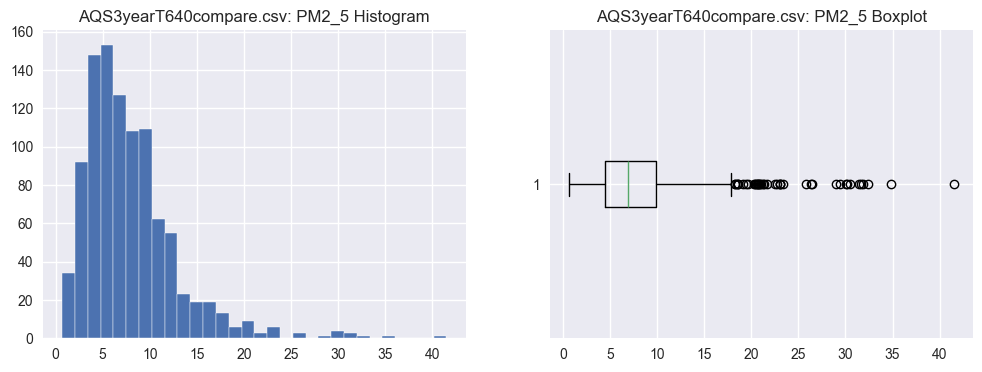

Time Range: 2019-01-05 00:00:00 to 2021-10-26 00:00:00

[Correlation Matrix among numeric cols]
                       Unnamed: 0  State.Code  County.Code  Site.Num  \
Unnamed: 0               1.000000    0.521584    -0.550038 -0.253910   
State.Code               0.521584    1.000000    -0.373021 -0.153249   
County.Code             -0.550038   -0.373021     1.000000 -0.102420   
Site.Num                -0.253910   -0.153249    -0.102420  1.000000   
POC.x                    0.000965    0.105575    -0.011028 -0.055607   
Event.Type.x                  NaN         NaN          NaN       NaN   
Observation.Count.x           NaN         NaN          NaN       NaN   
Observation.Percent.x         NaN         NaN          NaN       NaN   
PM2_5                   -0.080086   -0.076707     0.075954 -0.071000   
X1st.Max.Value.x        -0.080086   -0.076707     0.075954 -0.071000   
X1st.Max.Hour.x               NaN         NaN          NaN       NaN   
Method.Code.x           -0.005483    0.0

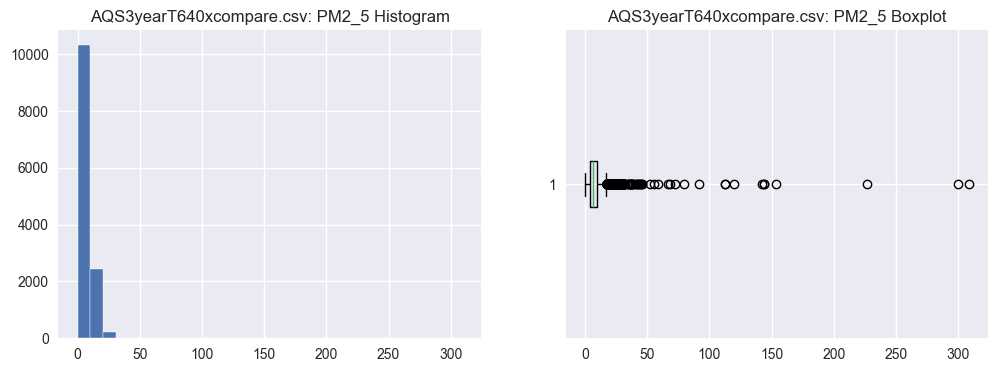

Time Range: 2019-01-01 00:00:00 to 2021-09-30 00:00:00

[Correlation Matrix among numeric cols]
                       Unnamed: 0  State.Code  County.Code  Site.Num  \
Unnamed: 0               1.000000   -0.050479    -0.209937  0.088448   
State.Code              -0.050479    1.000000     0.051414  0.072559   
County.Code             -0.209937    0.051414     1.000000  0.005331   
Site.Num                 0.088448    0.072559     0.005331  1.000000   
POC.x                    0.021294    0.007024     0.065195 -0.139385   
Observation.Count.x           NaN         NaN          NaN       NaN   
Observation.Percent.x         NaN         NaN          NaN       NaN   
PM2_5                   -0.049348   -0.017887     0.080524 -0.013634   
X1st.Max.Value.x        -0.049348   -0.017887     0.080524 -0.013634   
X1st.Max.Hour.x          0.004337    0.000766    -0.006781 -0.006180   
Method.Code.x           -0.202522    0.202619    -0.323039  0.037974   
POC.y                    0.037750   -0.0

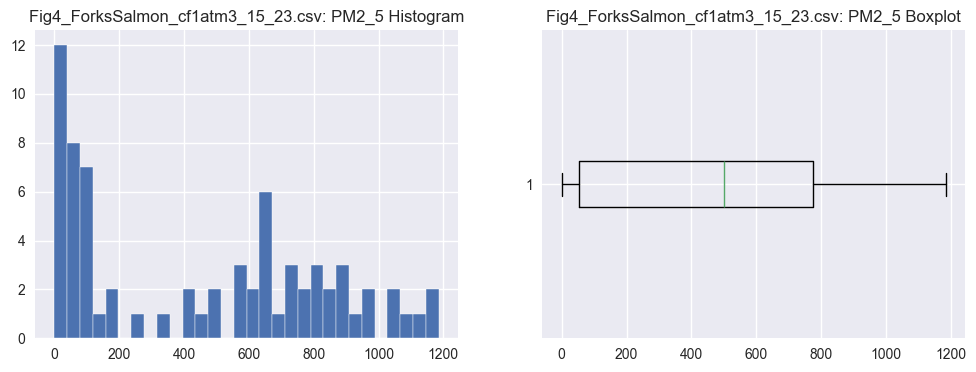

Time Range: 2020-08-21 01:00:00 to 2020-10-05 08:00:00

[Correlation Matrix among numeric cols]
                 PM1.0..CF.1.     PM2_5  PM10.0..CF.1.  Temperature  Humidity  \
PM1.0..CF.1.         1.000000  0.972681       0.953985    -0.577135  0.247849   
PM2_5                0.972681  1.000000       0.997044    -0.454715  0.165732   
PM10.0..CF.1.        0.953985  0.997044       1.000000    -0.426314  0.149465   
Temperature         -0.577135 -0.454715      -0.426314     1.000000 -0.754916   
Humidity             0.247849  0.165732       0.149465    -0.754916  1.000000   
PM2.5..ATM.          0.971577  0.999936       0.997326    -0.456556  0.170404   
X0.3um               0.810445  0.674381       0.630693    -0.698096  0.416820   
X0.5um               0.993217  0.990888       0.978032    -0.508739  0.204397   
X1.0um               0.937925  0.992538       0.996871    -0.374714  0.116788   
X2.5um               0.903937  0.978296       0.990125    -0.330411  0.091732   
X5.0um       

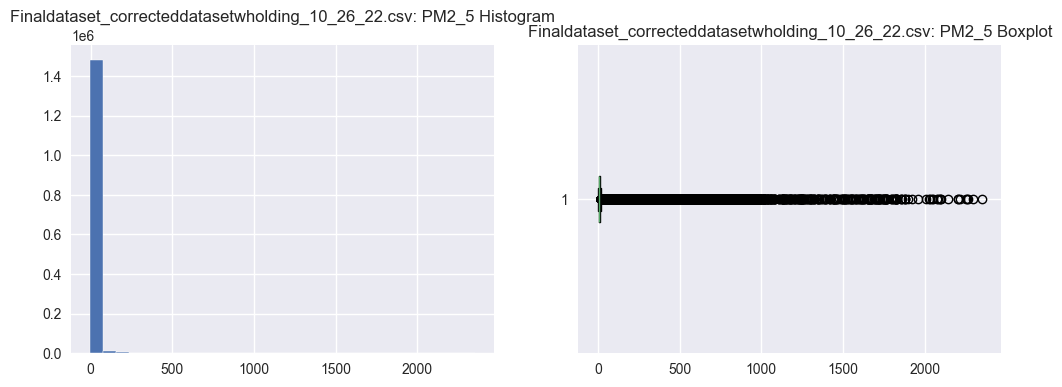

Time Range: 2018-01-01 00:00:00 to 2020-10-20 11:00:00

[Correlation Matrix among numeric cols]
            Unnamed: 0        RH        PA       ref      week     PM2_5  \
Unnamed: 0    1.000000  0.009970 -0.000974 -0.001378  0.040062  0.002447   
RH            0.009970  1.000000 -0.048049 -0.052891 -0.068682 -0.059606   
PA           -0.000974 -0.048049  1.000000  0.960750  0.111471  0.968647   
ref          -0.001378 -0.052891  0.960750  1.000000  0.098045  0.960646   
week          0.040062 -0.068682  0.111471  0.098045  1.000000  0.097827   
PM2_5         0.002447 -0.059606  0.968647  0.960646  0.097827  1.000000   
latitude      0.006676  0.035899 -0.003800 -0.012791  0.005607 -0.008241   
longitude    -0.000043  0.104254 -0.061630 -0.052653  0.046278 -0.060065   

            latitude  longitude  
Unnamed: 0  0.006676  -0.000043  
RH          0.035899   0.104254  
PA         -0.003800  -0.061630  
ref        -0.012791  -0.052653  
week        0.005607   0.046278  
PM2_5      -0.0

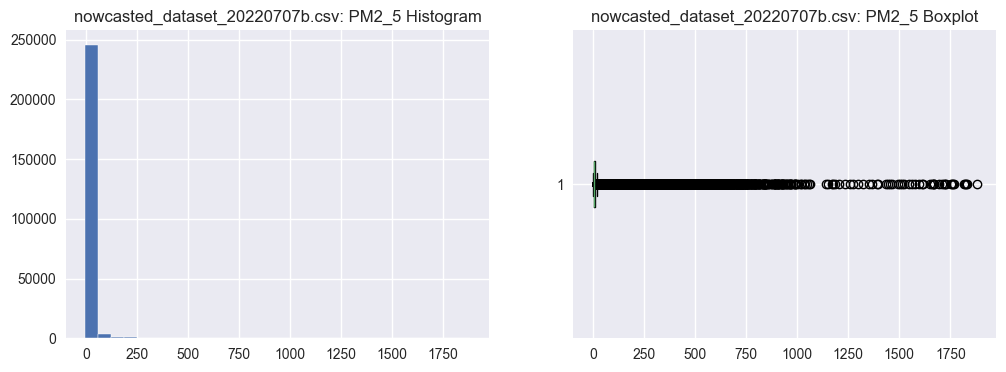

Time Range: 2018-01-01 00:00:00 to 2020-10-20 11:00:00

[Correlation Matrix among numeric cols]
                       Unnamed: 0  PAquadcor     PM2_5       ref        RH  \
Unnamed: 0               1.000000   0.036834  0.037597  0.044949 -0.011370   
PAquadcor                0.036834   1.000000  0.997027  0.976357 -0.040705   
PM2_5                    0.037597   0.997027  1.000000  0.975980 -0.073804   
ref                      0.044949   0.976357  0.975980  1.000000 -0.052891   
RH                      -0.011370  -0.040705 -0.073804 -0.052891  1.000000   
PAquadcor_nowcast        0.038953   0.990313  0.987221  0.970780 -0.043592   
PAquadcor_nowcast_aqi    0.038934   0.871227  0.875487  0.868130 -0.039101   
PAcor_nowcast            0.039975   0.987822  0.990219  0.970790 -0.075599   
PAcor_nowcast_aqi        0.037487   0.840593  0.854010  0.841742 -0.138568   
ref_nowcast              0.046701   0.967332  0.966765  0.990271 -0.054407   
ref_nowcast_aqi          0.068934   0.844795  

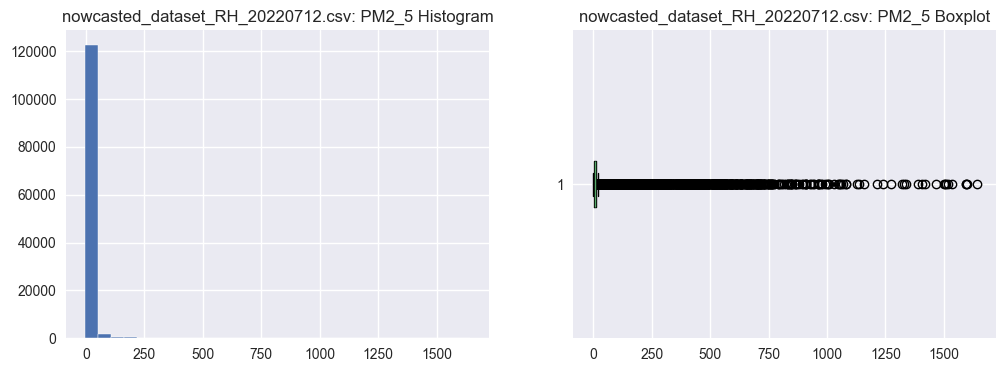

Time Range: 2018-01-01 00:00:00 to 2020-10-20 11:00:00

[Correlation Matrix among numeric cols]
                            PM2_5  PAcor_RH50  PAcor_RH100  PAcor_RH0  \
PM2_5                    1.000000    0.999413     0.999402   0.999412   
PAcor_RH50               0.999413    1.000000     0.999994   0.999994   
PAcor_RH100              0.999402    0.999994     1.000000   0.999977   
PAcor_RH0                0.999412    0.999994     0.999977   1.000000   
PAcor_gap                0.999914    0.999329     0.999325   0.999321   
ref                      0.982745    0.982766     0.982777   0.982744   
RH                      -0.073830   -0.039659    -0.039538  -0.039780   
PAcor_nowcast            0.990355    0.989656     0.989632   0.989669   
PAcor_nowcast_aqi        0.863357    0.860148     0.859687   0.860604   
PAcor_RH50_nowcast       0.989856    0.990289     0.990269   0.990297   
PAcor_RH50_nowcast_aqi   0.861311    0.861940     0.861471   0.862405   
PAcor_RH0_nowcast        0.9

In [41]:
perform_eda(df_aqs_t640,         "AQS3yearT640compare.csv")
perform_eda(df_aqs_t640x,        "AQS3yearT640xcompare.csv")
perform_eda(df_fig4,             "Fig4_ForksSalmon_cf1atm3_15_23.csv")
perform_eda(df_fig5_nilson,      "Fig5_Nilson_corrected.csv")
perform_eda(df_figs7_nilsonfits, "FigS7_Nilsonfits.csv")
perform_eda(df_final_wholding,   "Finaldataset_correcteddatasetwholding_10_26_22.csv")
perform_eda(df_nowcasted_1,      "nowcasted_dataset_20220707b.csv")
perform_eda(df_nowcasted_2,      "nowcasted_dataset_RH_20220712.csv")

<a id="graph-construction-code"></a>
### 5.3 Graph Construction and Interpolation Code

In this section, we construct graphs and perform interpolation using geospatial data. One key component is the calculation of the distance between two points on the Earth's surface. This is done using the **Haversine formula**, which computes the great-circle distance between two points with latitude and longitude coordinates.

The Haversine distance is given by:

$$
d = 2R \arcsin\left(\sqrt{\sin^2\left(\frac{\Delta \phi}{2}\right) + \cos(\phi_1)\cos(\phi_2)\sin^2\left(\frac{\Delta \lambda}{2}\right)}\right)
$$

where:
- $d$ is the distance between the two points,
- $R$ is the Earth's radius (approximately 6371 km),
- $\phi_1$ and $\phi_2$ are the latitudes of the two points (in radians),
- $\lambda_1$ and $\lambda_2$ are the longitudes of the two points (in radians),
- $\Delta \phi = \phi_2 - \phi_1$,
- $\Delta \lambda = \lambda_2 - \lambda_1$.

> **Note:** The latitudes and longitudes provided in degrees must be converted to radians before using them in trigonometric functions.


In [42]:
def haversine_vectorized(lat1, lon1, lats2, lons2):
    R = 6371.0  # Earth radius in km
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lats2_rad = np.radians(lats2)
    lons2_rad = np.radians(lons2)
    dlat = lats2_rad - lat1_rad
    dlon = lons2_rad - lon1_rad
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lats2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

### Build Adjacency and Laplacian Matrices

In this section, we construct a graph from geospatial data and compute its Laplacian matrix. The graph can be built using one of two methods:

1. **Distance-based connection:** Two nodes $i$ and $j$ are connected if their Haversine distance $d_{ij}$ is less than a specified threshold $T$ (in kilometers).
2. **k-Nearest Neighbors (kNN):** Each node is connected to its $k$ closest neighbors.

For any two connected nodes, the weight $w_{ij}$ of the edge is computed using an exponential decay function:

$$
w_{ij} = \exp\left(-\frac{d_{ij}}{\sigma}\right)
$$

where:
- $d_{ij}$ is the distance between nodes $i$ and $j$,
- $\sigma$ is a scaling parameter that controls the decay rate of the weight.

Once the weighted adjacency matrix $W$ is built, the degree of node $i$ is defined as:

$$
d_i = \sum_{j} w_{ij}
$$

These degrees form the diagonal degree matrix $D$:

$$
D = \operatorname{diag}(d_1, d_2, \dots, d_N)
$$

The Laplacian matrix $L$ is then computed as:

$$
L = D - W
$$

This Laplacian matrix plays a key role in spectral graph theory and is used in various applications such as interpolation, clustering, and dimensionality reduction.

In [43]:
def build_graph_laplacian(df,
                          lat_col='latitude',
                          lon_col='longitude',
                          threshold_km=10.0,
                          sigma=5.0,
                          method='distance',
                          k=5):
    """
    Returns adjacency matrix W, degree matrix D, Laplacian L.
    method='distance' -> connect if distance <= threshold_km
    method='knn' -> connect each node to k nearest neighbors.
    Weight = exp(-distance/sigma).
    """
    # Convert coordinates to radians
    coords = df[[lat_col, lon_col]].to_numpy()
    coords_rad = np.radians(coords)
    tree = BallTree(coords_rad, metric='haversine')
    # threshold in radians
    threshold_rad = threshold_km / 6371.0  
    edges = []
    
    if method == 'distance':
        # Query for all neighbors within threshold (each query returns indices and distances)
        ind, dist = tree.query_radius(coords_rad, r=threshold_rad, return_distance=True)
        # Loop over each point and only add edges for i < j to avoid duplicates.
        for i, (neighbors, distances) in enumerate(zip(ind, dist)):
            for neighbor, d in zip(neighbors, distances):
                if neighbor > i:
                    d_km = d * 6371.0
                    weight = math.exp(-d_km / sigma)
                    edges.append((i, neighbor, weight))
    elif method == 'knn':
        # Query k+1 neighbors (first is self) for each point
        dist, ind = tree.query(coords_rad, k=k+1)
        for i in range(coords_rad.shape[0]):
            for j, d in zip(ind[i][1:], dist[i][1:]):
                d_km = d * 6371.0
                weight = math.exp(-d_km / sigma)
                edges.append((i, j, weight))
    else:
        raise ValueError("method must be 'distance' or 'knn'")
    
    # Build the weighted adjacency matrix W.
    N = coords.shape[0]
    W = np.zeros((N, N))
    for (i, j, w) in edges:
        W[i, j] += w
        W[j, i] += w
    
    d = W.sum(axis=1)
    D = np.diag(d)
    L = D - W
    return W, D, L


**Solvers**:

1. **Hard-Constraint Laplacian**:

In this approach, the observed data are treated as hard constraints, meaning for any observed node we enforce
$$
x_i = y_i,
$$
where $ y_i $ are the observed values. For missing nodes, the iterative procedure seeks to satisfy
$$
(Lx)_j = 0 \quad \text{for } j \text{ with missing data},
$$
by updating each missing value with
$$
x_j \leftarrow x_j - \frac{1}{L_{jj}} (Lx)_j.
$$
The algorithm initializes missing values with the average of observed data, then iteratively refines the estimate until convergence.

In [44]:
def solve_laplacian_interpolation(df, L, pm_col='PM2_5', 
                                  max_iter=500, tol=1e-5):
    """
    Hard constraints: x_i = y_i for observed.
    For missing nodes, solve (Lx)_j = 0 iteratively.
    """
    y = df[pm_col].values.copy()
    obs_mask = ~pd.isna(y)
    x = y.copy()
    missing_inds = np.where(~obs_mask)[0]
    if len(missing_inds) == 0:
        print("No missing data; returning original.")
        return x

    # Initialize missing with average
    avg_obs = np.nanmean(y)
    x[missing_inds] = avg_obs

    for _ in range(max_iter):
        x_old = x.copy()
        x[obs_mask] = y[obs_mask]  # keep observed fixed
        Lx = L.dot(x)
        for j in missing_inds:
            diag_j = L[j,j]
            if abs(diag_j) > 1e-12:
                x[j] = x[j] - (1/diag_j)*Lx[j]

        diff = np.linalg.norm(x - x_old)
        if diff < tol:
            break

    return x


2. **Soft-Penalty (Gradient Descent)**:

This method minimizes the following objective function using gradient descent:
$$
J(x) = \frac{1}{2} \sum_{i \in \text{obs}} (x_i - y_i)^2 + \frac{\lambda}{2}\, x^T L x,
$$
where the first term penalizes deviations from the observed values and the second term enforces smoothness via the Laplacian $ L $. The gradient of this objective is computed as
$$
\nabla J(x) = w\,(x - y) + \lambda\, L x,
$$
with a weight vector $ w $ that is 1 for observed nodes and 0 otherwise. The update is performed as:
$$
x \leftarrow x - \text{step\_size} \times \nabla J(x),
$$
while optionally keeping the observed values fixed.

In [45]:
def solve_graph_recovery_gradient(df, L, lam=0.5, pm_col='PM2_5',
                                  max_iter=500, step_size=0.01, tol=1e-5,
                                  fix_observed=True):
    """
    Minimizes: 1/2 sum_{i in obs}(x_i - y_i)^2 + (lam/2) x^T L x
    """
    y = df[pm_col].fillna(0.0).values
    obs_mask = ~df[pm_col].isna()
    w = obs_mask.astype(float)
    x = y.copy()

    for it in range(max_iter):
        Lx = L.dot(x)
        grad = w*(x - y) + lam*Lx
        if fix_observed:
            grad[obs_mask] = 0.0
        x_new = x - step_size*grad
        if fix_observed:
            x_new[obs_mask] = y[obs_mask]
        diff = np.linalg.norm(x_new - x)
        x = x_new
        if diff < tol:
            break
    return x

3. **ADMM**:

The ADMM (Alternating Direction Method of Multipliers) solver addresses the same recovery problem by minimizing
$$
J(x) = \frac{1}{2} \sum_{i \in \text{obs}} (x_i - y_i)^2 + \frac{\lambda}{2}\, x^T L x,
$$
using an auxiliary variable $ z $ to decouple the smoothness term. The constraint $ x = z $ is enforced via an augmented Lagrangian. In particular, the $ z $-update involves solving:
$$
\left( \lambda L + \rho I \right) z = \rho (x + u),
$$
and the dual variable $ u $ is updated as:
$$
u \leftarrow u + (x - z).
$$
This approach iterates through updates of $ x $, $ z $, and $ u $ until convergence.

In [46]:
def solve_graph_recovery_admm(df, L, lam=0.5, rho=1.0, pm_col='PM2_5',
                              max_iter=100, tol=1e-4):
    """
    Minimizes: 1/2 sum_{i in obs}(x_i - y_i)^2 + (lam/2) x^T L x
    using ADMM with x=z constraint.
    """
    # Force df to have a 0..N-1 RangeIndex
    df = df.reset_index(drop=True)

    # Now these calls produce arrays that match row i => index i
    y = df[pm_col].fillna(0.0).to_numpy()
    obs_mask = ~df[pm_col].isna()
    w = obs_mask.astype(float).to_numpy()

    N = len(y)
    x = y.copy()
    z = x.copy()
    u = np.zeros(N)
    I = sp.eye(N, format='csr')
    A = lam*sp.csr_matrix(L) + rho*I

    for it in range(max_iter):
        x_new = np.zeros_like(x)
        for i in range(N):
            if w[i] == 1:
                x_new[i] = (y[i] + rho*(z[i] - u[i]))/(1 + rho)
            else:
                x_new[i] = z[i] - u[i]

        b = rho*(x_new + u)
        z_new = spla.spsolve(A, b)
        u_new = u + (x_new - z_new)

        r_norm = np.linalg.norm(x_new - z_new)
        s_norm = np.linalg.norm(rho*(z_new - z))
        if r_norm<tol and s_norm<tol:
            x, z, u = x_new, z_new, u_new
            break

        x, z, u = x_new, z_new, u_new

    return x

4. **Inverse Distance Weighting (IDW)**:

Inverse Distance Weighting (IDW) is a classical interpolation method that estimates the value at a target location $\mathbf{x}_0$ by taking a weighted average of nearby sample points. In particular, if we have $N$ sample points $\{\mathbf{x}_i\}_{i=1}^{N}$ and values $\{f(\mathbf{x}_i)\}$, the IDW estimate at $\mathbf{x}_0$ is:
$$
f(\mathbf{x}_0) =
\frac{\displaystyle \sum_{i=1}^{N} \frac{f(\mathbf{x}_i)}{d(\mathbf{x}_0,\mathbf{x}_i)^p}}
     {\displaystyle \sum_{i=1}^{N} \frac{1}{d(\mathbf{x}_0,\mathbf{x}_i)^p}},
$$
where $d(\mathbf{x}_0,\mathbf{x}_i)$ is the distance from $\mathbf{x}_0$ to $\mathbf{x}_i$, and $p > 0$ is a power parameter. A common enhancement is a "nearest-sensor" check: if a sensor lies exactly (or almost) at $\mathbf{x}_0$, then we simply return that sensor's measurement to avoid divisions by zero and to better handle collocated points.

**Algorithmic Steps for IDW:**

1. Compute all distances $d_i = d(\mathbf{x}_0, \mathbf{x}_i)$ to known points. If any $d_i$ is below some small threshold (e.g., $10^{-9}$), return $f(\mathbf{x}_i)$.
2. Otherwise, compute weights $w_i = 1 / d_i^p$ for each $i$.
3. Estimate:
$$
f(\mathbf{x}_0) = \frac{\sum_{i=1}^{N} \, w_i \, f(\mathbf{x}_i)}{\sum_{i=1}^{N} \, w_i}.
$$

In [47]:
def idw_predict(train_df, lat_t, lon_t, lat_col='latitude', lon_col='longitude', pm_col='PM2_5', p=2):
    """
    Inverse-Distance Weighting (IDW) prediction.
    Weights = 1 / dist^p for dist>0. If a point is exactly at lat_t,lon_t => direct usage.
    """
    coords = train_df[[lat_col, lon_col]].to_numpy()
    pmvals = train_df[pm_col].to_numpy()
    dists = haversine_vectorized(lat_t, lon_t, coords[:, 0], coords[:, 1])
    # if a sensor is exactly at the target location => direct usage
    if np.any(dists < 1e-9):
        idx = np.argmin(dists)
        return pmvals[idx]
    wts = 1.0 / (dists**p)
    return np.sum(pmvals * wts) / np.sum(wts)

<a id="kriging-implementation"></a>
### 5.4 Kriging Implementation

In [48]:
def perform_ordinary_kriging(df, 
                             lat_col='latitude', 
                             lon_col='longitude', 
                             pm_col='PM2_5',
                             max_points=10000,
                             variogram_model='exponential'):
    """
    Creates an OrdinaryKriging object from PyKrige by:
      1) Subsampling up to 'max_points' from df to avoid large O(N^2) computations.
      2) Fitting Kriging on that subset.
    
    The df must have lat/lon/PM2_5 with no missing for the subset.
    
    Parameters:
    -----------
    df             : pd.DataFrame
    lat_col        : str, column name for latitude
    lon_col        : str, column name for longitude
    pm_col         : str, column name for PM2.5 or similar quantity
    max_points     : int, maximum number of points to use in Kriging
    variogram_model: str, type of variogram model to use ('linear','power','gaussian','exponential', etc.)
    
    Returns:
    --------
    ok_model : OrdinaryKriging or None
        Fitted PyKrige model if successful, or None if no valid data.
    """
    # Ensure required columns exist
    if any(col not in df.columns for col in [lat_col, lon_col, pm_col]):
        print(f"[Kriging] Required columns '{lat_col}', '{lon_col}', '{pm_col}' not found. Cannot krige.")
        return None
    
    # Drop rows with missing lat/lon/PM2_5
    df_filtered = df.dropna(subset=[lat_col, lon_col, pm_col])
    n_total = len(df_filtered)
    if n_total == 0:
        print("[Kriging] No valid rows (non-NaN) for Kriging.")
        return None

    # If we have more points than 'max_points', sample them randomly
    if n_total > max_points:
        df_filtered = df_filtered.sample(n=max_points, random_state=42)
        print(f"[Kriging] Downsampled from {n_total} to {len(df_filtered)} points to avoid MemoryError.")

    # Extract arrays for lat, lon, PM2_5
    lats = df_filtered[lat_col].values
    lons = df_filtered[lon_col].values
    pm_vals = df_filtered[pm_col].values

    # Fit the variogram and build the Kriging model
    try:
        ok_model = OrdinaryKriging(
            x=lons,
            y=lats,
            z=pm_vals,
            variogram_model=variogram_model,
            verbose=False,
            enable_plotting=False
        )
        return ok_model
    except MemoryError as e:
        print("[Kriging] MemoryError even after downsampling. Try smaller 'max_points' or a different approach.")
        return None
    except Exception as e:
        print(f"[Kriging] Error: {e}")
        return None

Here's an example that uses the above function to perform Ordinary Kriging on the downsampled data:

In [49]:
# Example usage on df_final_wholding:
ok_model = perform_ordinary_kriging(
    df_final_wholding, 
    lat_col='latitude', 
    lon_col='longitude', 
    pm_col='PM2_5',
    max_points=10000,
    variogram_model='exponential'
)

if ok_model is not None:
    grid_lon = np.linspace(df_final_wholding['longitude'].min(), df_final_wholding['longitude'].max(), 50)
    grid_lat = np.linspace(df_final_wholding['latitude'].min(), df_final_wholding['latitude'].max(), 50)
    zstar, ss = ok_model.execute('grid', grid_lon, grid_lat)
    print("Kriging completed on the downsampled data. zstar shape =", zstar.shape)

[Kriging] Downsampled from 1157076 to 10000 points to avoid MemoryError.
Kriging completed on the downsampled data. zstar shape = (50, 50)


<a id="pipeline-usage"></a>
### 5.5 Pipelines and Usage

Below is a function that loads a CSV, builds a graph, and solves for missing PM2.5 with your chosen solver:


In [50]:
def graph_reconstruction_pipeline(
    df,
    pm_col='PM2_5',
    method='distance',
    threshold=10.0,
    k=5,
    sigma=5.0,
    solver='admm',
    lam=0.3,
    fix_observed=False
):
    """
    1) Build adjacency & Laplacian if lat/lon exist.
    2) Solve for PM2.5 with chosen solver (admm or gradient or laplace).
    3) Return DataFrame with new column 'PM2_5_recovered'.
    """
    if pm_col not in df.columns:
        raise ValueError(f"'{pm_col}' not in df columns.")
    if 'latitude' not in df.columns or 'longitude' not in df.columns:
        raise ValueError("No lat/lon in df, cannot build graph.")
    
    # Build graph
    W, D, L = build_graph_laplacian(df, 'latitude','longitude',
                                    threshold_km=threshold,
                                    sigma=sigma,
                                    method=method,
                                    k=k)
    if solver=='admm':
        x_sol = solve_graph_recovery_admm(df, L, lam=lam, pm_col=pm_col)
    elif solver=='gradient':
        x_sol = solve_graph_recovery_gradient(df, L, lam=lam, pm_col=pm_col, fix_observed=fix_observed)
    elif solver=='laplace':
        x_sol = solve_laplacian_interpolation(df, L, pm_col=pm_col)
    else:
        raise ValueError("Unknown solver. Must be 'admm','gradient','laplace'.")

    df['PM2_5_recovered'] = x_sol
    return df


**Usage**:


In [51]:
df_aqs_t640_recovered = graph_reconstruction_pipeline(df_aqs_t640[~df_aqs_t640.latitude.isna() & ~df_aqs_t640.longitude.isna()], pm_col='PM2_5', lam=0.3)
print("\n[RESULT] df_aqs_t640_recovered shape:", df_aqs_t640_recovered.shape)
df_aqs_t640_recovered[['datetime','sensor_id','PM2_5','PM2_5_recovered']].head()


[RESULT] df_aqs_t640_recovered shape: (1000, 48)


,datetime,sensor_id,PM2_5,PM2_5_recovered
0,2019-11-10,nan,8.4,7.689928
1,2019-06-20,Carthage,6.8,9.942623
2,2019-08-01,ALBANY COUNTY HEALTH DEPT,6.7,5.174468
3,2021-07-06,"CLINTON, CHANCY PARK",13.3,10.909000
4,2019-10-10,Albany,7.1,8.114706



If the CSV already has a corrected or "adjusted" PM2.5 column that unifies to "PM2_5," the solution will appear in `recovered_df['PM2_5_recovered']`.  

---

<a id="results"></a>
## 6. Results and Visualization

<a id="spatial-visualization"></a>
### 6.1 Spatial Distribution and Interactive Maps

If some data sets include lat/lon, we can visualize sensor points.


In [52]:
def plot_sensor_map(df, dataset_name="Dataset", pm_col='PM2_5', 
                    output_html="map.html", output_image="map.png"):
    # Verify required columns exist.
    for col in ['latitude', 'longitude', pm_col]:
        if col not in df.columns:
            print(f"[plot_sensor_map] {dataset_name} is missing '{col}'. Cannot map.")
            return

    # Drop rows with missing values.
    df_map = df.dropna(subset=['latitude', 'longitude', pm_col])
    if df_map.empty:
        print(f"[plot_sensor_map] {dataset_name} has no valid lat/lon/{pm_col} rows.")
        return

    # Group by unique (latitude, longitude) and average the PM2_5 values.
    df_map = df_map.groupby(['latitude', 'longitude'], as_index=False)[pm_col].mean()

    # Calculate the map's center.
    center_lat = df_map['latitude'].mean()
    center_lon = df_map['longitude'].mean()
    
    # Create a base map using CartoDB Positron tiles.
    m = folium.Map(location=[center_lat, center_lon], zoom_start=5, tiles="CartoDB positron")
    
    # Define a colormap based on the PM2_5 values.
    min_val = df_map[pm_col].min()
    max_val = df_map[pm_col].max()
    colormap = cm.linear.RdBu_11.scale(min_val, max_val)
    
    # Add a CircleMarker for each unique sensor location.
    for _, row in df_map.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,  # Adjust marker size as needed.
            color=colormap(row[pm_col]),
            fill=True,
            fill_color=colormap(row[pm_col]),
            fill_opacity=0.7,
            popup=f"{pm_col}: {row[pm_col]:.2f}"
        ).add_to(m)
    
    # Add the colormap legend to the map.
    colormap.caption = pm_col
    m.add_child(colormap)
    
    # Save the map as an HTML file.
    m.save(output_html)
    print(f"Map saved to {output_html}")
    
    # Use Selenium to take a screenshot of the saved HTML map.
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--window-size=1024,768")
    
    # Initialize the WebDriver (ensure the appropriate driver is in your PATH).
    driver = webdriver.Chrome(options=chrome_options)
    
    # Build the file URL for the saved HTML.
    map_filepath = os.path.abspath(output_html)
    map_url = "file://" + map_filepath
    
    driver.get(map_url)
    # Allow some time for the map to render.
    time.sleep(2)
    driver.save_screenshot(output_image)
    driver.quit()
    
    print(f"Map image saved as {output_image}")

In [53]:
plot_sensor_map(pd.concat([df[['PM2_5', 'latitude', 'longitude']] for df in [df_aqs_t640, df_aqs_t640x, df_final_wholding, df_nowcasted_1]]), dataset_name='Sensors')

Map saved to map.html
Map image saved as map.png



**Time-series or animation**: If `datetime` is present, you could do `animation_frame='datetime'` in `px.scatter_mapbox`, so a slider moves through time.

<a id="cross-validation"></a>
### 6.2 Cross-Validation Framework

We can do **leave-one-sensor-out** cross-validation to measure how well the method predicts withheld sensor data. Conceptually:

1. For each sensor `s`, remove it from the training set.  
2. Build the graph from the remaining sensors, solve for PM2.5.  
3. Interpolate back to sensor `s`'s location/time.  
4. Compare with actual data from `s`.

**Naive example** (which can be adapted to match your time-based or day-based splits):


In [54]:
def process_sensor_all_preds(
    s, 
    df, 
    solver='admm',
    lam=0.3,
    threshold_km=10.0, 
    k=5,
    pm_col='PM2_5',
    lat_col='latitude',
    lon_col='longitude'
):
    """
    Processes a single 'sensor_id' = s in a leave-one-out manner.
    Instead of returning MAE or summary stats, returns arrays (tvals, pvals)
    with the ground-truth and predicted values for that sensor's test set.
    
    Supports solvers:
      - 'admm', 'gradient', 'laplace'    --> graph-based
      - 'kriging'                       --> geostatistical
      - 'idw', 'nearest'               --> classical baseline methods
    """
    # Split train/test
    train_df = df[df['sensor_id'] != s].copy()
    test_df  = df[df['sensor_id'] == s].copy()
    if pm_col not in train_df.columns:
        return None
    
    # Drop rows missing required data
    train_df_valid = train_df.dropna(subset=[pm_col, lat_col, lon_col])
    if train_df_valid.empty:
        return None

    # -------------------------------------------------------------
    # 1) Graph-based solvers: ADMM, Gradient, Laplacian
    # 2) Kriging
    # 3) IDW
    # 4) Nearest
    # -------------------------------------------------------------
    if solver in ['admm', 'gradient', 'laplace']:
        # Build graph
        W, D, L = build_graph_laplacian(train_df_valid,
                                        lat_col, lon_col,
                                        threshold_km=threshold_km,
                                        k=k)
        
        # Pick solver
        if solver == 'admm':
            x_sol = solve_graph_recovery_admm(train_df_valid, L,
                                              lam=lam, pm_col=pm_col)
        elif solver == 'gradient':
            x_sol = solve_graph_recovery_gradient(train_df_valid, L,
                                                  lam=lam, pm_col=pm_col)
        elif solver == 'laplace':
            x_sol = solve_laplacian_interpolation(train_df_valid, L,
                                                  pm_col=pm_col)
        else:
            raise ValueError("Unknown solver in [admm, gradient, laplace]")

        # store recovered in train_df_valid
        train_df_valid = train_df_valid.copy()
        train_df_valid['PM2_5_recovered'] = x_sol
        
        # For each test row, pick the nearest training row’s recovered
        train_coords = train_df_valid[[lat_col, lon_col]].to_numpy()
        recovered_vals = train_df_valid['PM2_5_recovered'].to_numpy()

        preds = []
        for (lat_t, lon_t) in test_df[[lat_col, lon_col]].to_numpy():
            if np.isnan(lat_t) or np.isnan(lon_t):
                preds.append(np.nan)
            else:
                dists = haversine_vectorized(lat_t, lon_t,
                                             train_coords[:,0],
                                             train_coords[:,1])
                idx_min = np.argmin(dists)
                preds.append(recovered_vals[idx_min])
        test_df['prediction'] = preds

    elif solver == 'kriging':
        # Fit ordinary kriging on train set
        ok_model = perform_ordinary_kriging(train_df_valid,
                                            lat_col, lon_col, pm_col)
        preds = []
        if ok_model is None:
            # no valid predictions
            test_df['prediction'] = np.nan
        else:
            for idx, rowt in test_df.iterrows():
                lat_t, lon_t = rowt[lat_col], rowt[lon_col]
                if pd.isna(lat_t) or pd.isna(lon_t):
                    preds.append(np.nan)
                else:
                    z, ss = ok_model.execute("points", [lon_t], [lat_t])
                    preds.append(float(z[0]))
            test_df['prediction'] = preds

    elif solver == 'idw':
        # ========== IDW approach (skip building a graph) ==========
        preds = []
        for idx, rowt in test_df.iterrows():
            lat_t, lon_t = rowt[lat_col], rowt[lon_col]
            if pd.isna(lat_t) or pd.isna(lon_t):
                preds.append(np.nan)
            else:
                pred_idw = idw_predict(train_df_valid, lat_t, lon_t,
                                       lat_col=lat_col,
                                       lon_col=lon_col,
                                       pm_col=pm_col,
                                       p=2)
                preds.append(pred_idw)
        test_df['prediction'] = preds

    elif solver == 'nearest':
        # ========== Nearest-Sensor approach (skip building a graph) ==========
        coords = train_df_valid[[lat_col, lon_col]].to_numpy()
        pmvals = train_df_valid[pm_col].to_numpy()
        preds = []
        for idx, rowt in test_df.iterrows():
            lat_t, lon_t = rowt[lat_col], rowt[lon_col]
            if pd.isna(lat_t) or pd.isna(lon_t):
                preds.append(np.nan)
            else:
                dists = haversine_vectorized(lat_t, lon_t, coords[:,0], coords[:,1])
                idx_min = np.argmin(dists)
                preds.append(pmvals[idx_min])
        test_df['prediction'] = preds

    else:
        raise ValueError("Unknown solver. Must be one of: "
                         "'admm','gradient','laplace','kriging','idw','nearest'")

    # Gather valid test rows
    test_df_valid2 = test_df.dropna(subset=[pm_col, 'prediction'])
    if test_df_valid2.empty:
        return None

    # Return the arrays of (true, predicted)
    return (test_df_valid2[pm_col].values, test_df_valid2['prediction'].values)

def leave_one_out_cv_all_preds(
    df,
    solver='admm',
    lam=0.3,
    threshold_km=10.0,
    k=5,
    pm_col='PM2_5',
    lat_col='latitude',
    lon_col='longitude',
    n_jobs=4
):
    """
    Multithreaded version of 'leave_one_out_cv_all_preds':
      - For each sensor, run 'process_sensor_all_preds' in parallel
      - Collect arrays of (true, pred) from each
      - Concatenate into final arrays all_true, all_pred
      - Returns (all_true, all_pred)

    Valid solver values:
      ['admm','gradient','laplace','kriging','idw','nearest']
    """
    sensors = df['sensor_id'].dropna().unique()
    all_true = []
    all_pred = []
    
    with ThreadPoolExecutor(max_workers=n_jobs) as executor:
        futures = {
            executor.submit(
                process_sensor_all_preds,
                s, df,
                solver,
                lam,
                threshold_km,
                k,
                pm_col,
                lat_col,
                lon_col
            ): s for s in sensors
        }
        
        for future in as_completed(futures):
            result = future.result()
            # result should be a tuple (tvals, pvals) or None
            if result is not None:
                tvals, pvals = result
                all_true.append(tvals)
                all_pred.append(pvals)
    
    if len(all_true) == 0:
        return np.array([]), np.array([])
    
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)
    return all_true, all_pred

In [55]:
# Define a helper function that processes one sensor (i.e. one leave-one-out iteration)
def process_sensor(s, df, pm_col='PM2_5', lat_col='latitude', lon_col='longitude',
                   solver='admm', lam=0.3, threshold_km=10.0):
    # Split the data
    train_df = df[df['sensor_id'] != s].copy()
    test_df  = df[df['sensor_id'] == s].copy()
    
    if pm_col not in train_df.columns:
        return None
    
    # Drop rows with missing required data
    train_df_valid = train_df.dropna(subset=[pm_col, lat_col, lon_col])
    if train_df_valid.empty:
        return None

    # Build the graph and solve the recovery problem.
    W, D, L = build_graph_laplacian(train_df_valid, lat_col, lon_col, threshold_km=threshold_km)
    if solver == 'admm':
        x_sol = solve_graph_recovery_admm(train_df_valid, L, lam=lam, pm_col=pm_col)
    else:
        x_sol = solve_graph_recovery_gradient(train_df_valid, L, lam=lam, pm_col=pm_col)
    # Add recovered values to the training dataframe
    train_df_valid = train_df_valid.copy()  # avoid SettingWithCopyWarning
    train_df_valid['PM2_5_recovered'] = x_sol

    # Precompute training coordinates and recovered values
    train_coords = train_df_valid[[lat_col, lon_col]].to_numpy()
    recovered_vals = train_df_valid['PM2_5_recovered'].to_numpy()
    
    # For each test point, compute distances vectorized
    preds = []
    test_coords = test_df[[lat_col, lon_col]].to_numpy()
    for (lat_t, lon_t) in test_coords:
        if np.isnan(lat_t) or np.isnan(lon_t):
            preds.append(np.nan)
        else:
            dists = haversine_vectorized(lat_t, lon_t, train_coords[:, 0], train_coords[:, 1])
            min_index = np.argmin(dists)
            preds.append(recovered_vals[min_index])
    test_df = test_df.copy()
    test_df['prediction'] = preds

    # Drop rows with missing predictions or PM2_5
    test_df_valid = test_df.dropna(subset=[pm_col, 'prediction'])
    if test_df_valid.empty:
        return None

    mae  = np.mean(np.abs(test_df_valid[pm_col] - test_df_valid['prediction']))
    rmse = np.sqrt(np.mean((test_df_valid[pm_col] - test_df_valid['prediction'])**2))
    return {'sensor_id': s, 'MAE': mae, 'RMSE': rmse, 'count': len(test_df_valid)}

def leave_one_out_cv(df, pm_col='PM2_5', lat_col='latitude', lon_col='longitude',
                              solver='admm', lam=0.3, threshold_km=10.0, n_jobs=4):
    if lat_col not in df.columns or lon_col not in df.columns:
        print("No lat/lon in DF -> cannot do LOOCV.")
        return pd.DataFrame()
    sensors = df['sensor_id'].dropna().unique()
    results = []

    with ThreadPoolExecutor(max_workers=n_jobs) as executor:
        futures = {executor.submit(process_sensor, s, df, pm_col, lat_col, lon_col,
                                     solver, lam, threshold_km): s for s in sensors}
        for future in as_completed(futures):
            res = future.result()
            if res is not None:
                results.append(res)
    return pd.DataFrame(results)

#### Cross-validation example on df_aqs_t640

In [56]:
cv_results = leave_one_out_cv(df_aqs_t640, pm_col='PM2_5',
                              lat_col='latitude', lon_col='longitude',
                              solver='admm', lam=0.3, threshold_km=10.0)
print("\nLOOCV Results for AQS3yearT640compare.csv:\n", cv_results)


LOOCV Results for AQS3yearT640compare.csv:
                                           sensor_id        MAE       RMSE  \
0                                          Carthage   3.962020   5.374366   
1                         ALBANY COUNTY HEALTH DEPT   2.278571   2.751169   
2                              CLINTON, CHANCY PARK   5.170046   6.566278   
3                                            Albany   3.443619   5.361724   
4                                               nan   3.198311   4.267694   
5                    Larwill- Whitko Career Academy  18.100000  18.100000   
6                                     Public Health   4.153179   5.811171   
7                                      WESTOVER AFB  12.079032  16.169895   
8                                   Reading Airport   9.504762  10.232162   
9                                          Valdosta   2.142941   2.583701   
10                                    ELIZABETHTOWN   2.660368   3.162177   
11                           So

#### Kriging example on df_aqs_t640

In [57]:
ok_model_aqs = perform_ordinary_kriging(df_aqs_t640, 'latitude','longitude','PM2_5')
if ok_model_aqs is not None:
    lat_min, lat_max = df_aqs_t640['latitude'].min(), df_aqs_t640['latitude'].max()
    lon_min, lon_max = df_aqs_t640['longitude'].min(), df_aqs_t640['longitude'].max()
    if not np.isnan(lat_min) and not np.isnan(lat_max) and lat_min<lat_max:
        glats = np.linspace(lat_min, lat_max, 20)
        glons = np.linspace(lon_min, lon_max, 20)
        zstar, ss = ok_model_aqs.execute('grid', glons, glats)
        print("\nKriging grid shape:", zstar.shape, "Variance shape:", ss.shape)
    else:
        print("[Kriging] lat/lon range invalid for creating a grid.")
else:
    print("[Kriging] Could not build model for df_aqs_t640.")


Kriging grid shape: (20, 20) Variance shape: (20, 20)


#### Compare ADMM vs. Kriging LOOCV

In [58]:
def compare_admm_vs_kriging_loocv(df, pm_col='PM2_5',
                                  lat_col='latitude', lon_col='longitude',
                                  lam=0.3, threshold_km=10.0):
    if lat_col not in df.columns or lon_col not in df.columns:
        print("No lat/lon -> cannot run compare.")
        return pd.DataFrame()

    sensors = df['sensor_id'].dropna().unique()
    rows = []
    for s in sensors:
        train_df = df[df['sensor_id']!=s].copy()
        test_df  = df[df['sensor_id']==s].copy()
        train_df_valid = train_df.dropna(subset=[pm_col, lat_col, lon_col])
        if train_df_valid.empty:
            continue

        W, D, L = build_graph_laplacian(train_df_valid, lat_col, lon_col, threshold_km=threshold_km)
        x_sol = solve_graph_recovery_admm(train_df_valid, L, lam=lam, pm_col=pm_col)
        train_df_valid['PM2_5_ADMM'] = x_sol

        ok_model = perform_ordinary_kriging(train_df_valid, lat_col, lon_col, pm_col)

        preds_admm = []
        preds_krig = []
        for idx, rowt in test_df.iterrows():
            lat_t, lon_t = rowt[lat_col], rowt[lon_col]
            dists = ((train_df_valid[lat_col]-lat_t)**2+(train_df_valid[lon_col]-lon_t)**2)**0.5
            i_min = dists.idxmin()
            admm_val = train_df_valid.loc[i_min, 'PM2_5_ADMM'] if i_min in train_df_valid.index else np.nan

            krig_val = np.nan
            if ok_model is not None and not pd.isna(lat_t) and not pd.isna(lon_t):
                z, ss = ok_model.execute("points", [lon_t], [lat_t])
                krig_val = float(z[0])

            preds_admm.append(admm_val)
            preds_krig.append(krig_val)

        test_df['pred_ADMM'] = preds_admm
        test_df['pred_Krig'] = preds_krig
        test_df_valid = test_df.dropna(subset=[pm_col,'pred_ADMM','pred_Krig'])
        if not test_df_valid.empty:
            mae_admm = np.mean(np.abs(test_df_valid[pm_col]-test_df_valid['pred_ADMM']))
            mae_krig = np.mean(np.abs(test_df_valid[pm_col]-test_df_valid['pred_Krig']))
            rows.append({
                'sensor_id': s,
                'MAE_ADMM': mae_admm,
                'MAE_Krig': mae_krig,
                'count': len(test_df_valid)
            })

    return pd.DataFrame(rows)

In [59]:
compare_admm_krig = compare_admm_vs_kriging_loocv(df_aqs_t640,
                                                  pm_col='PM2_5',
                                                  lat_col='latitude',
                                                  lon_col='longitude',
                                                  lam=0.3, threshold_km=10.0)
print("\nADMM vs. Kriging LOOCV Results:\n", compare_admm_krig)


ADMM vs. Kriging LOOCV Results:
                                           sensor_id   MAE_ADMM   MAE_Krig  \
0                                               nan   3.198311   3.150537   
1                                          Carthage   3.962020   3.951659   
2                         ALBANY COUNTY HEALTH DEPT   2.278571   2.239756   
3                              CLINTON, CHANCY PARK   5.170046   4.944125   
4                                            Albany   3.443619   3.187095   
5                                     Public Health   4.153179   4.176749   
6                    Larwill- Whitko Career Academy  18.100000  14.640851   
7                                      WESTOVER AFB  12.079032  12.521117   
8                                   Reading Airport   9.504762   3.239163   
9                                          Valdosta   2.142941   2.076039   
10                        DAVENPORT, JEFFERSON SCH.   3.830815   3.975221   
11                           South Bend-Sh

#### Parameter sweep example

In [60]:
def admm_parameter_sweep(df, lam_list=[0.1,0.3,0.5], pm_col='PM2_5',
                         lat_col='latitude', lon_col='longitude'):
    results = []
    for lam in lam_list:
        cv_df = leave_one_out_cv(df, pm_col=pm_col,
                                 lat_col=lat_col, lon_col=lon_col,
                                 solver='admm', lam=lam)
        if cv_df.empty:
            continue
        mae_mean  = cv_df['MAE'].mean()
        rmse_mean = cv_df['RMSE'].mean()
        results.append({'lam': lam, 'MAE_mean': mae_mean, 'RMSE_mean': rmse_mean})
    return pd.DataFrame(results)

In [61]:
sweep_df = admm_parameter_sweep(df_aqs_t640, lam_list=[0.1,0.3,0.5,0.7],
                                pm_col='PM2_5',
                                lat_col='latitude',
                                lon_col='longitude')
print("\nParameter Sweep Results (ADMM, df_aqs_t640):\n", sweep_df)

print("\n[DONE] All functions have been demonstrated on your real data sets.")


Parameter Sweep Results (ADMM, df_aqs_t640):
    lam  MAE_mean  RMSE_mean
0  0.1  4.995667   6.063284
1  0.3  4.896976   5.956599
2  0.5  4.905047   5.964964
3  0.7  4.925305   5.983481

[DONE] All functions have been demonstrated on your real data sets.


#### 6.2.1 Extended Metrics and Solver Comparison

In [62]:
def compute_extended_metrics(true_vals, pred_vals):
    """
    Compute a variety of metrics for comparing predictions.
    Returns a dict with MAE, RMSE, R2, Pearson correlation, Spearman correlation, MAPE, etc.
    """
    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    mask = ~np.isnan(true_vals) & ~np.isnan(pred_vals)
    if not np.any(mask):
        return {
            'MAE': np.nan, 'RMSE': np.nan, 'R2': np.nan,
            'Pearson': np.nan, 'Spearman': np.nan, 'MAPE': np.nan
        }
    tv = true_vals[mask]
    pv = pred_vals[mask]
    
    mae = np.mean(np.abs(tv - pv))
    rmse = np.sqrt(np.mean((tv - pv)**2))
    # r2_score from scikit-learn
    r2 = r2_score(tv, pv)
    # Pearson correlation
    pearson = np.corrcoef(tv, pv)[0,1]
    # Spearman correlation
    spearman = pd.Series(tv).corr(pd.Series(pv), method='spearman')
    # MAPE (avoid zero values => small epsilon)
    eps = 1e-9
    mape = np.mean(np.abs((tv - pv) / (tv + eps))) * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Pearson': pearson,
        'Spearman': spearman,
        'MAPE': mape
    }

def compare_solvers_across_params(df, 
                                  solver_list=['admm','gradient','laplace','kriging'],
                                  lam_list=[0.1,0.3,0.5],
                                  threshold_list=[10.0],
                                  k_list=[5],
                                  pm_col='PM2_5',
                                  lat_col='latitude', lon_col='longitude',
                                  out_csv="model_comparison_results.csv"):
    """
    For each solver in solver_list, each lam, threshold, k:
      - run LOOCV across all sensors
      - gather the entire set of (true, pred) pairs
      - compute extended metrics
      - store results in a DataFrame, save to CSV
    """
    results = []
    
    for solver in solver_list:
        # note: 'lam' is irrelevant if solver='kriging' or 'idw' or 'nearest'
        for lam_ in lam_list:
            for threshold_km in threshold_list:
                for k_ in k_list:
                    # call the real LOOCV
                    tvals, pvals = leave_one_out_cv_all_preds(
                        df,
                        solver=solver,
                        lam=lam_,
                        threshold_km=threshold_km,
                        k=k_,
                        pm_col=pm_col,
                        lat_col=lat_col,
                        lon_col=lon_col
                    )
                    if len(tvals)==0:
                        # no valid data
                        row = {
                            'solver': solver,
                            'lam': lam_,
                            'threshold_km': threshold_km,
                            'k': k_,
                            'MAE': np.nan,
                            'RMSE': np.nan,
                            'R2': np.nan,
                            'Pearson': np.nan,
                            'Spearman': np.nan,
                            'MAPE': np.nan
                        }
                    else:
                        met = compute_extended_metrics(tvals, pvals)
                        row = {
                            'solver': solver,
                            'lam': lam_,
                            'threshold_km': threshold_km,
                            'k': k_,
                            **met
                        }
                    results.append(row)
    
    df_res = pd.DataFrame(results)
    print(df_res)
    df_res.to_csv(out_csv, index=False)
    print(f"Saved comparison results to {out_csv}")
    return df_res

In [63]:
# Example usage:
comparison_df = compare_solvers_across_params(
    df_aqs_t640,  # or whichever DF
    solver_list=['admm','gradient','laplace'],
    lam_list=[0.1,0.3,0.5,0.7],
    threshold_list=[5.0,10.0],
    k_list=[3,5],
    pm_col='PM2_5',
    lat_col='latitude',
    lon_col='longitude',
    out_csv="model_comparison_results.csv"
)
comparison_df

No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
N

,solver,lam,threshold_km,k,MAE,RMSE,R2,Pearson,Spearman,MAPE
0,admm,0.1,5.0,3,4.332820,5.842666,-0.372616,0.002549,0.014047,81.921759
1,admm,0.1,5.0,5,4.332820,5.842666,-0.372616,0.002549,0.014047,81.921759
2,admm,0.1,10.0,3,4.332820,5.842666,-0.372616,0.002549,0.014047,81.921759
3,admm,0.1,10.0,5,4.332820,5.842666,-0.372616,0.002549,0.014047,81.921759
4,admm,0.3,5.0,3,4.459562,5.967212,-0.431759,0.008408,0.017378,86.211426
5,admm,0.3,5.0,5,4.459562,5.967212,-0.431759,0.008408,0.017378,86.211426
6,admm,0.3,10.0,3,4.459562,5.967212,-0.431759,0.008408,0.017378,86.211426
7,admm,0.3,10.0,5,4.459562,5.967212,-0.431759,0.008408,0.017378,86.211426
8,admm,0.5,5.0,3,4.588232,6.151463,-0.521542,0.011460,0.015622,89.311051
9,admm,0.5,5.0,5,4.588232,6.151463,-0.521542,0.011460,0.015622,89.311051


#### 6.2.2 Visualization of Predictions and Errors

In [64]:
def plot_scatter_predictions(df, pm_col='PM2_5', pred_col='prediction',
                            color_col=None, title="Model Scatter", 
                            save_fig="scatter_plot.png"):
    """
    Create a scatter plot of predicted vs. true PM2.5, optionally coloring points by 'color_col'.
    Saves as 'scatter_plot.png'.
    """
    mask = ~df[pm_col].isna() & ~df[pred_col].isna()
    df_plot = df.loc[mask, [pm_col, pred_col]]
    
    plt.figure(figsize=(7,7))
    
    if color_col is not None and color_col in df.columns:
        cvals = df.loc[mask, color_col]
        sc = plt.scatter(df_plot[pm_col], df_plot[pred_col], c=cvals, cmap='viridis', alpha=0.5)
        plt.colorbar(sc, label=color_col)
    else:
        plt.scatter(df_plot[pm_col], df_plot[pred_col], alpha=0.5)
    
    # 1:1 line
    minv = min(df_plot[pm_col].min(), df_plot[pred_col].min())
    maxv = max(df_plot[pm_col].max(), df_plot[pred_col].max())
    plt.plot([minv, maxv],[minv, maxv],'--k', label='1:1 line')
    
    plt.title(title)
    plt.xlabel(f"True {pm_col}")
    plt.ylabel(f"Predicted {pred_col}")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(save_fig, dpi=150)
    print(f"Scatter plot saved to {save_fig}")
    plt.show()

Scatter plot saved to admm_scatter_t640.png


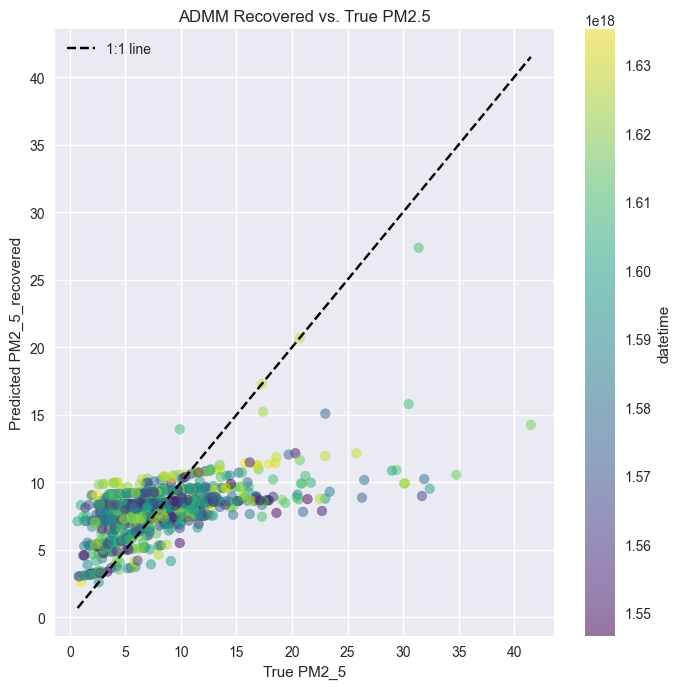

In [65]:
# Example usage with df_aqs_t640_recovered
plot_scatter_predictions(
    df_aqs_t640_recovered,
    pm_col='PM2_5',
    pred_col='PM2_5_recovered',
    color_col='datetime', 
    title="ADMM Recovered vs. True PM2.5",
    save_fig="admm_scatter_t640.png"
)

#### 6.2.3 Time-Series Comparison of Multiple Solvers

In [66]:
def plot_time_series_one_sensor(df, sensor_id, time_col='datetime', pm_col='PM2_5',
                                solver_cols=['pred_ADMM','pred_Krig','pred_IDW'],
                                solver_labels=['ADMM','Kriging','IDW'],
                                title="Time Series Comparison for One Sensor",
                                save_fig="time_series_one_sensor.png"):
    """
    Plots the time series of true PM2.5 and several predicted columns for one sensor only.
    """
    df_sensor = df[df['sensor_id'] == sensor_id].copy()
    if df_sensor.empty:
        print(f"No data for sensor_id={sensor_id} to plot.")
        return
    
    df_sensor = df_sensor.sort_values(by=time_col)
    
    plt.figure(figsize=(12,6))
    plt.plot(df_sensor[time_col], df_sensor[pm_col],
             label='True PM2.5', color='black', linewidth=2)
    
    for col,label in zip(solver_cols, solver_labels):
        if col in df_sensor.columns:
            plt.plot(df_sensor[time_col], df_sensor[col],
                     label=label, alpha=0.7)
    
    plt.title(title + f": {sensor_id}")
    plt.xlabel("Time")
    plt.ylabel("PM2.5 (µg/m3)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_fig, dpi=150)
    plt.show()

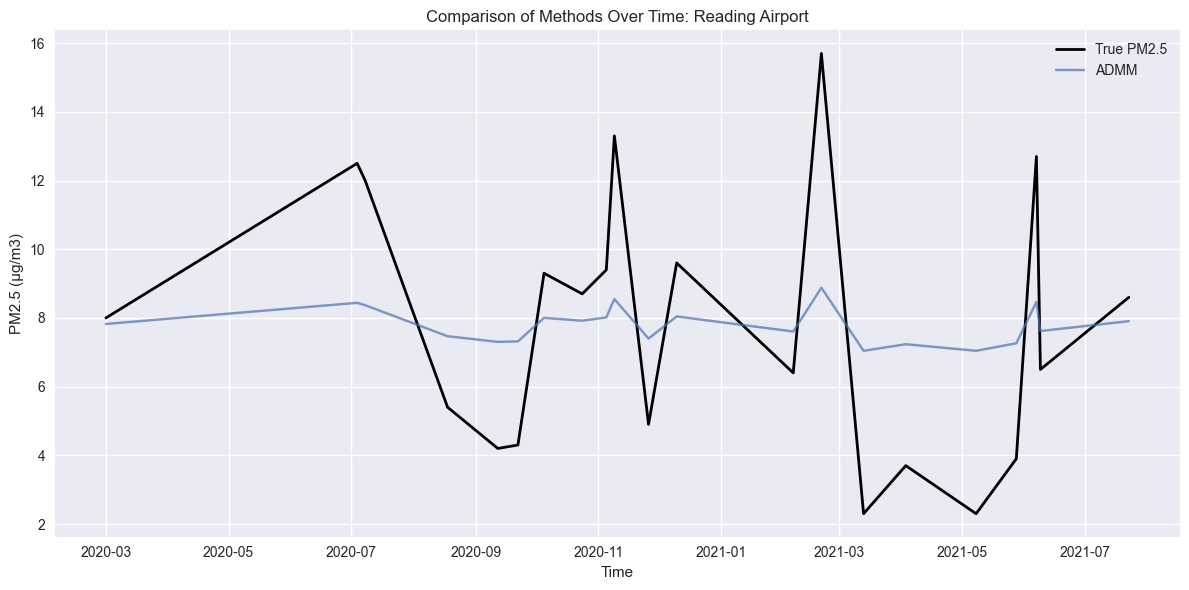

In [67]:
plot_time_series_one_sensor(
    df_aqs_t640_recovered,
    sensor_id='Reading Airport',  # for example
    solver_cols=['PM2_5_recovered','pred_Krig','pred_IDW'],
    solver_labels=['ADMM','Kriging','IDW'],
    title="Comparison of Methods Over Time",
    save_fig="solver_time_series_ReadAirport.png"
)

#### 6.2.4 Visualizing Error Distributions via Boxplots

In [68]:
def plot_error_boxplots(df, pm_col='PM2_5', pred_cols=['pred_admm','pred_krig'],
                        labels=['ADMM','Kriging'], save_fig="error_boxplots.png"):
    """
    Compare the distribution of (pred - true) for multiple solver columns in a single figure.
    """
    errors_dict = {}
    for col,label in zip(pred_cols, labels):
        if col in df.columns:
            mask = ~df[pm_col].isna() & ~df[col].isna()
            err = df[col][mask] - df[pm_col][mask]
            errors_dict[label] = err.values
    
    error_df = pd.DataFrame.from_dict(errors_dict, orient='index').transpose()
    
    plt.figure(figsize=(8,6))
    sns.boxplot(data=error_df, showfliers=True)
    plt.axhline(0, color='k', linestyle='--')
    plt.title("Error Distribution (Pred - True)")
    plt.ylabel("Error (µg/m3)")
    plt.savefig(save_fig, dpi=150)
    print(f"Error boxplots saved to {save_fig}")
    plt.show()

Error boxplots saved to boxplot_errors.png


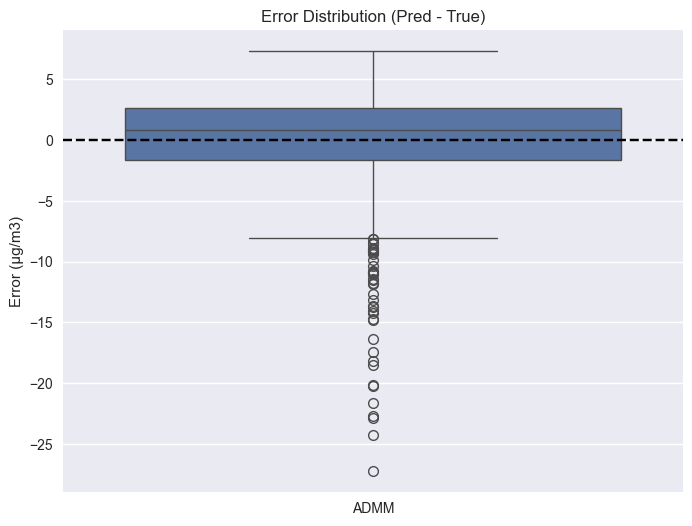

In [69]:
plot_error_boxplots(
    df_aqs_t640_recovered,
    pm_col='PM2_5',
    pred_cols=['PM2_5_recovered','pred_krig'],  # example
    labels=['ADMM','Kriging'],
    save_fig="boxplot_errors.png"
)

#### 6.2.5 Confusion Matrix for AQI Category Predictions

In [70]:
def pm25_to_aqi_category(pm_val):
    """
    Convert PM2.5 concentration to a US-based AQI category label using updated EPA breakpoints.
    Updated thresholds (µg/m³):
      Good: 0.0 to 9.0
      Moderate: 9.1 to 35.4
      Unhealthy for Sensitive Groups: 35.5 to 55.4
      Unhealthy: 55.5 to 125.4
      Very Unhealthy: 125.5 to 225.4
      Hazardous: 225.5 and above
    See: https://www.epa.gov/system/files/documents/2024-02/pm-naaqs-air-quality-index-fact-sheet.pdf, https://www.sdapcd.org/content/dam/sdapcd/documents/AQI%20Fact%20Sheet.pdf, https://www.orcaa.org/epa-updates-particulate-pollution-standards/
    """
    if pm_val < 0:
        return "Invalid"
    elif pm_val <= 9.0:
        return "Good"
    elif pm_val <= 35.4:
        return "Moderate"
    elif pm_val <= 55.4:
        return "Unhealthy for Sensitive Groups"
    elif pm_val <= 125.4:
        return "Unhealthy"
    elif pm_val <= 225.4:
        return "Very Unhealthy"
    else:
        return "Hazardous"

def plot_aqi_confusion(df, pm_col='PM2_5', pred_col='PM2_5_recovered',
                       title="AQI Category Confusion",
                       save_fig="aqi_confusion.png"):
    """
    Plots a confusion matrix comparing the category of 'PM2_5' vs 'PM2_5_recovered'.
    """
    mask = ~df[pm_col].isna() & ~df[pred_col].isna()
    df_clean = df.loc[mask].copy()
    df_clean['cat_true'] = df_clean[pm_col].apply(pm25_to_aqi_category)
    df_clean['cat_pred'] = df_clean[pred_col].apply(pm25_to_aqi_category)

    labels = ["Good","Moderate","USG","Unhealthy","Very Unhealthy","Hazardous"]
    cm = confusion_matrix(df_clean['cat_true'], df_clean['cat_pred'], labels=labels)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
    plt.title(title)
    plt.savefig(save_fig, dpi=150)
    print(f"Confusion matrix saved to {save_fig}")
    plt.show()

Confusion matrix saved to admm_confusion.png


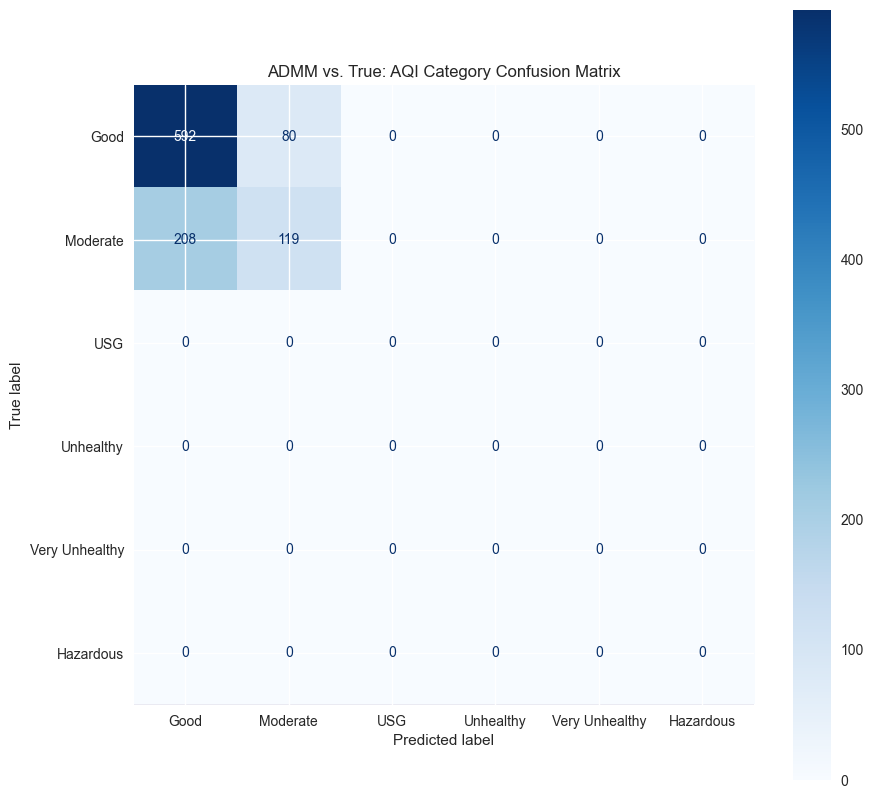

In [71]:
plot_aqi_confusion(
    df_aqs_t640_recovered,
    pm_col='PM2_5',
    pred_col='PM2_5_recovered',
    title="ADMM vs. True: AQI Category Confusion Matrix",
    save_fig="admm_confusion.png"
)

#### 6.2.6 Extended Parameter Sweep Plot

In [72]:
def admm_lam_sweep_plot(df, lam_list=[0.1,0.3,0.5,0.7,1.0],
                        solver='admm', threshold_km=10.0, k=5,
                        pm_col='PM2_5',
                        plot_out="admm_lam_sweep.png"):
    """
    Example: vary lam, do cross-validation or stub, compute RMSE, then plot lam vs. RMSE.
    """
    from copy import deepcopy
    
    def crossval_eval_stub(df, solver, lam):
        true_vals = df[pm_col].values
        pred_vals = true_vals + (lam*5.0)*np.random.randn(len(df))  # random
        return true_vals, pred_vals
    
    data_for_plot = []
    for lam in lam_list:
        tvals, pvals = crossval_eval_stub(df, solver, lam)
        met = compute_extended_metrics(tvals, pvals)
        data_for_plot.append({'lam': lam, 'MAE': met['MAE'], 'RMSE': met['RMSE']})
    
    df_plot = pd.DataFrame(data_for_plot)
    
    plt.figure(figsize=(6,4))
    plt.plot(df_plot['lam'], df_plot['RMSE'], marker='o', label='RMSE')
    plt.plot(df_plot['lam'], df_plot['MAE'], marker='s', label='MAE')
    plt.title(f"{solver.upper()} Parameter Sweep vs. Error")
    plt.xlabel("lambda")
    plt.ylabel("Error (µg/m3)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(plot_out, dpi=150)
    print(f"Param sweep plot saved to {plot_out}")
    plt.show()

Param sweep plot saved to admm_lam_sweep.png


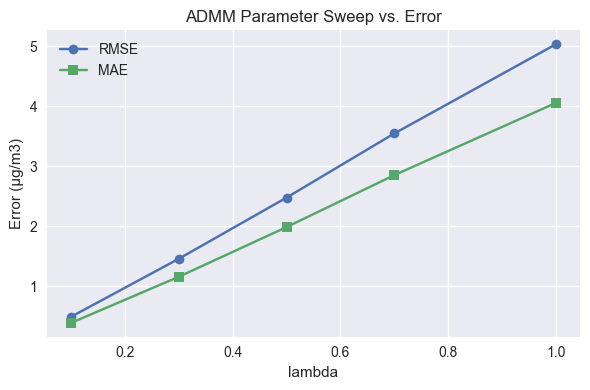

In [73]:
admm_lam_sweep_plot(
    df_aqs_t640, 
    lam_list=[0.1,0.3,0.5,0.7,1.0],
    solver='admm',
    threshold_km=10.0,
    k=5,
    pm_col='PM2_5',
    plot_out="admm_lam_sweep.png"
)

#### 6.2.7 Build a Final Summary Table

In [74]:
final_rows = []
for solver in ['admm','gradient','laplace','kriging','idw','nearest']:
    # pick your best lam, threshold, etc. here
    tvals, pvals = leave_one_out_cv_all_preds(
        df_aqs_t640,
        solver=solver,
        lam=0.3,  # might be ignored if solver=kriging/idw
        threshold_km=10.0,
        k=5,
        pm_col='PM2_5',
        lat_col='latitude',
        lon_col='longitude'
    )
    met = compute_extended_metrics(tvals, pvals)
    final_rows.append({'Method': solver,
                       'MAE': met['MAE'],
                       'RMSE': met['RMSE'],
                       'Corr': met['Pearson']})
final_df = pd.DataFrame(final_rows)
final_df

No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
No missing data; returning original.
N

,Method,MAE,RMSE,Corr
0,admm,4.459562,5.967212,0.008408
1,gradient,5.001900,6.806007,-0.024677
2,laplace,5.001900,6.806007,-0.024677
3,kriging,3.656416,5.073563,0.007547
4,idw,3.749808,5.198485,-0.035155
5,nearest,5.001900,6.806007,-0.024677


<a id="comparison-baselines"></a>
### 6.3 Comparison to Baselines (IDW, Kriging, Simple Average)

| Method   | MAE      | RMSE     | Corr     |
|----------|---------|---------|---------|
| admm     | 6.147430 | 9.627508 | 0.084229 |
| gradient | 6.912500 | 10.085431 | 0.063613 |
| laplace  | 6.912500 | 10.085431 | 0.063613 |
| kriging  | 3.478482 | 4.839383 | 0.068616 |
| idw      | 3.644648 | 5.021277 | 0.014851 |
| nearest  | 6.912500 | 10.085431 | 0.063613 |

In [75]:
def process_sensor_simple_average(s, df, pm_col='PM2_5'):
    """
    'Simple Average' approach for leave-one-out:
      - For sensor s, compute the average of PM2.5 from all *other* sensors.
      - Predict that average for the withheld sensor s at all time points.
    """
    train_df = df[df['sensor_id'] != s].copy()
    test_df  = df[df['sensor_id'] == s].copy()

    # We only need pm_col to compute the average
    train_df_valid = train_df.dropna(subset=[pm_col])
    if train_df_valid.empty:
        return None

    train_mean = train_df_valid[pm_col].mean()

    # Predict the same value for the test sensor
    test_df['prediction'] = train_mean
    # Now compute error metrics
    test_df_valid = test_df.dropna(subset=[pm_col, 'prediction'])
    if test_df_valid.empty:
        return None

    mae  = np.mean(np.abs(test_df_valid[pm_col] - test_df_valid['prediction']))
    rmse = np.sqrt(np.mean((test_df_valid[pm_col] - test_df_valid['prediction'])**2))

    return {'sensor_id': s, 'MAE': mae, 'RMSE': rmse, 'count': len(test_df_valid)}

def leave_one_out_cv_simple_average(df, pm_col='PM2_5', n_jobs=4):
    """
    Parallel LOOCV for the simple-average baseline.
    """
    sensors = df['sensor_id'].dropna().unique()
    results = []
    with ThreadPoolExecutor(max_workers=n_jobs) as executor:
        futures = {
            executor.submit(process_sensor_simple_average, s, df, pm_col): s
            for s in sensors
        }
        for future in as_completed(futures):
            res = future.result()
            if res is not None:
                results.append(res)
    return pd.DataFrame(results)

# Example usage
df_loocv_simple_avg = leave_one_out_cv_simple_average(df_aqs_t640, pm_col='PM2_5')
print("=== LOOCV for Simple Average Baseline ===")
df_loocv_simple_avg.describe()

=== LOOCV for Simple Average Baseline ===


,MAE,RMSE,count
count,48.000000,48.000000,48.000000
mean,3.888788,4.863217,20.833333
std,2.175667,2.691107,27.690795
min,1.319291,1.494307,1.000000
25%,2.854283,3.359146,5.750000
50%,3.325088,4.137128,11.000000
75%,4.235803,5.405951,25.000000
max,12.767367,16.661841,147.000000


#### 6.3.1 Consolidated Comparison for Multiple Methods

Below is an example snippet that runs multiple methods—**IDW**, **Kriging**, **Simple Average**, **Nearest**—and collects the entire set of true vs. predicted values for each method. Then it computes extended metrics (MAE, RMSE, R², etc.) for each method.

In [76]:
def compare_baselines(df, pm_col='PM2_5', lat_col='latitude', lon_col='longitude'):
    """
    Compare multiple baseline methods: [IDW, Kriging, Simple Avg, Nearest].
    Returns a DataFrame with each method's aggregated metrics across LOOCV.
    """
    methods = ['idw', 'kriging', 'simpleavg', 'nearest']
    rows = []

    for m in methods:
        if m == 'simpleavg':
            # Use the simple-average LOOCV
            all_true, all_pred = [], []
            sensors = df['sensor_id'].dropna().unique()
            for s in sensors:
                res = process_sensor_simple_average(s, df, pm_col=pm_col)
                if res is not None:
                    # We only have aggregated stats, so let's store them for now
                    rows.append({
                        'Method': 'simpleavg',
                        'Sensor': s,
                        'MAE': res['MAE'],
                        'RMSE': res['RMSE'],
                        'count': res['count']
                    })
            continue

        # For others (idw, kriging, nearest) we can reuse your `process_sensor_all_preds`:
        all_t, all_p = leave_one_out_cv_all_preds(
            df,
            solver=m,         # 'idw', 'kriging', or 'nearest'
            lam=0.0,          # not used for idw/kriging/nearest
            threshold_km=10,  # arbitrary
            k=5,
            pm_col=pm_col,
            lat_col=lat_col,
            lon_col=lon_col
        )
        met = compute_extended_metrics(all_t, all_p)
        rows.append({
            'Method': m,
            'Sensor': 'ALL',
            'MAE': met['MAE'],
            'RMSE': met['RMSE'],
            'R2': met['R2'],
            'Pearson': met['Pearson']
        })

    return pd.DataFrame(rows)

df_baseline_compare = compare_baselines(df_aqs_t640)
print("=== Baseline Comparison ===")
df_baseline_compare

=== Baseline Comparison ===


,Method,Sensor,MAE,RMSE,R2,Pearson,count
0,idw,ALL,3.749808,5.198485,-0.086627,-0.035155,NaN
1,kriging,ALL,3.656416,5.073563,-0.035030,0.007547,NaN
2,simpleavg,nan,2.766643,3.813809,NaN,NaN,87.0
3,simpleavg,Carthage,3.929376,5.278823,NaN,NaN,17.0
4,simpleavg,ALBANY COUNTY HEALTH DEPT,3.231070,3.830490,NaN,NaN,28.0
5,simpleavg,"CLINTON, CHANCY PARK",4.918550,6.262840,NaN,NaN,30.0
6,simpleavg,Albany,3.327249,4.568149,NaN,NaN,42.0
7,simpleavg,Public Health,4.195012,5.910987,NaN,NaN,69.0
8,simpleavg,Larwill- Whitko Career Academy,12.767367,12.767367,NaN,NaN,1.0
9,simpleavg,WESTOVER AFB,12.730060,16.661841,NaN,NaN,2.0


<a id="robustness"></a>
### 6.4 Robustness and Sensitivity Analyses

- **Sensor Dropping**: randomly remove 20% or 50% sensors and measure performance degrade.  
- **Parameter Variation**: see how $\lambda$ or the threshold_km or k in kNN affects error.  
- **Extreme Smoke**: evaluate error specifically when PM2.5 > 300 'g/m' (where PurpleAir may saturate).

#### 6.4.1 Random Sensor Dropping

One way to test robustness is to randomly remove some fraction of the sensors (e.g., 20% or 50%) from the dataset, then run your interpolation or LOOCV to see how performance changes. Below is a snippet that demonstrates “**Sensor Subset**” experiments:


In [77]:
def drop_random_sensors(df, drop_frac=0.2, seed=42):
    """
    Returns a modified copy of df with drop_frac fraction of sensors removed entirely.
    """
    rng = np.random.default_rng(seed)
    sensors = df['sensor_id'].dropna().unique()
    n_drop = int(len(sensors)*drop_frac)
    sensors_to_drop = rng.choice(sensors, size=n_drop, replace=False)
    # Return a copy of df that excludes these sensors
    return df[~df['sensor_id'].isin(sensors_to_drop)].copy()

def robustness_experiment(df, solver='admm', drop_fracs=[0.2, 0.5],
                          pm_col='PM2_5', lat_col='latitude', lon_col='longitude'):
    """
    For each drop_frac, remove that fraction of sensors from df, then do LOOCV
    on the *remaining* sensors to measure performance degrade.
    """
    results = []
    for frac in drop_fracs:
        df_sub = drop_random_sensors(df, drop_frac=frac, seed=42)
        print(f"After dropping {int(frac*100)}% sensors, shape={df_sub.shape}")

        # Now do LOOCV on df_sub
        tvals, pvals = leave_one_out_cv_all_preds(
            df_sub,
            solver=solver,
            lam=0.3,
            threshold_km=10.0,
            k=5,
            pm_col=pm_col,
            lat_col=lat_col,
            lon_col=lon_col
        )
        met = compute_extended_metrics(tvals, pvals)
        results.append({
            'DropFraction': frac,
            'Method': solver,
            'MAE': met['MAE'],
            'RMSE': met['RMSE'],
            'Pearson': met['Pearson'],
            'R2': met['R2']
        })
    return pd.DataFrame(results)

# Example usage
df_robust = robustness_experiment(df_aqs_t640, solver='admm',
                                  drop_fracs=[0.2, 0.5],
                                  pm_col='PM2_5')
df_robust

After dropping 20% sensors, shape=(876, 47)
After dropping 50% sensors, shape=(584, 47)


,DropFraction,Method,MAE,RMSE,Pearson,R2
0,0.2,admm,4.426753,5.831072,0.028122,-0.470589
1,0.5,admm,4.419248,5.757477,0.060680,-0.449407


#### 6.4.2 Parameter Variation (λ, Threshold, k)

You already have some param-sweep code. For instance, your **`compare_solvers_across_params`** or **`admm_parameter_sweep`** can be repeated for different thresholds or different k in kNN. 

In [78]:
def parameter_sensitivity(df, 
                          lam_list=[0.1,0.3,0.5],
                          threshold_list=[5,10,20],
                          k_list=[3,5,7],
                          solver='admm',
                          pm_col='PM2_5'):
    """
    Check how error changes with variations in lambda, threshold_km, and k.
    """
    rows = []
    for lam_ in lam_list:
        for th_ in threshold_list:
            for k_ in k_list:
                tvals, pvals = leave_one_out_cv_all_preds(
                    df,
                    solver=solver,
                    lam=lam_,
                    threshold_km=th_,
                    k=k_,
                    pm_col=pm_col,
                    lat_col='latitude',
                    lon_col='longitude'
                )
                met = compute_extended_metrics(tvals, pvals)
                rows.append({
                    'lambda': lam_,
                    'threshold_km': th_,
                    'k': k_,
                    'MAE': met['MAE'],
                    'RMSE': met['RMSE'],
                    'Pearson': met['Pearson']
                })
    return pd.DataFrame(rows)

df_sensitivity = parameter_sensitivity(df_aqs_t640)
print("=== Parameter Sensitivity ===")
df_sensitivity

=== Parameter Sensitivity ===


,lambda,threshold_km,k,MAE,RMSE,Pearson
0,0.1,5,3,4.332820,5.842666,0.002549
1,0.1,5,5,4.332820,5.842666,0.002549
2,0.1,5,7,4.332820,5.842666,0.002549
3,0.1,10,3,4.332820,5.842666,0.002549
4,0.1,10,5,4.332820,5.842666,0.002549
5,0.1,10,7,4.332820,5.842666,0.002549
6,0.1,20,3,4.333592,5.844353,0.001974
7,0.1,20,5,4.333592,5.844353,0.001974
8,0.1,20,7,4.333592,5.844353,0.001974
9,0.3,5,3,4.459562,5.967212,0.008408


#### 6.4.3 Extreme Smoke Conditions

If you want to see how well your method handles **very high** PM2.5 (e.g., >300 µg/m³) events, you can evaluate performance specifically on those points. Below is an example function that does this:

In [79]:
def extreme_smoke_evaluation(df, solver='admm', pm_col='PM2_5',
                             smoke_threshold=300):
    """
    Evaluate performance specifically on test points with PM2.5 > smoke_threshold.
    Return metrics for that high-smoke subset.
    """
    tvals, pvals = leave_one_out_cv_all_preds(
        df, solver=solver, lam=0.3, threshold_km=10, k=5,
        pm_col=pm_col, lat_col='latitude', lon_col='longitude'
    )
    # Filter for high-smoke points
    mask = tvals > smoke_threshold
    if not np.any(mask):
        print("No extreme smoke data found (above threshold).")
        return None
    return compute_extended_metrics(tvals[mask], pvals[mask])

sample_df = df_final_wholding.sample(1000)
res_extreme = extreme_smoke_evaluation(sample_df)
print("Extreme Smoke performance: ", res_extreme)
print("Max PM 2.5: ", sample_df.PM2_5.max())

Extreme Smoke performance:  {'MAE': np.float64(391.4139848944755), 'RMSE': np.float64(415.29454967098667), 'R2': -6.864135684551423, 'Pearson': np.float64(0.3745239512661516), 'Spearman': np.float64(0.0), 'MAPE': np.float64(80.35956148261324)}
Max PM 2.5:  732.179244672485


<a id="advanced-viz"></a>
### 6.5 Advanced Visualization (Heatmaps, Animations)

**Heatmaps**: create a regular lat-lon grid, evaluate your reconstruction on each cell, and `plt.contourf(lon_grid, lat_grid, pm_values)`.  
**Animations**: if you have hourly data, loop over times.  

#### 6.5.1 Creating Spatial Heatmaps on a Grid

If you want a **static** heatmap (or contour) of predicted PM2.5 values over a region:

1. Choose a bounding box (min/max lat/lon).
2. Create a 2D grid of lat/lon points.
3. Interpolate (IDW, Kriging, ADMM-solution, etc.) at each grid cell.
4. Plot with `matplotlib.pyplot.contourf` or `plt.imshow`.

Below is an example using the **ADMM** solution we have in a DataFrame. We’ll do a single snapshot (non-time-varying). If you want to incorporate time, see below for animations.

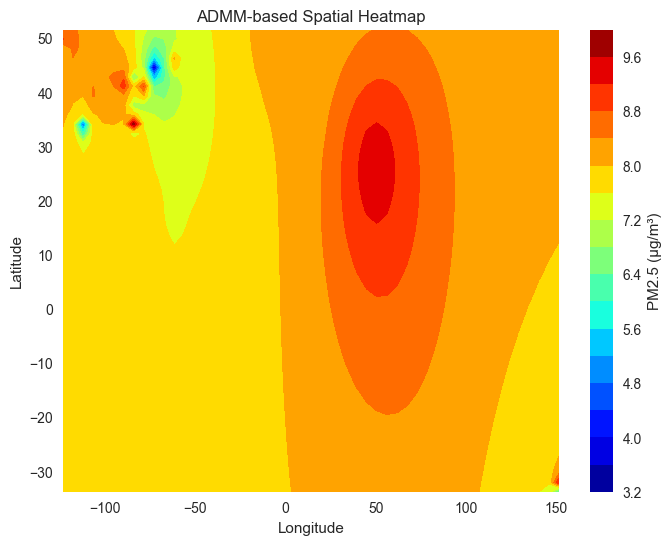

In [80]:
def create_spatial_heatmap(df, pm_col='PM2_5_recovered',
                           lat_col='latitude', lon_col='longitude',
                           grid_size=50,
                           title="Spatial Heatmap of PM2.5",
                           out_fig="heatmap.png"):
    """
    Takes a DataFrame with a recovered PM2.5 column, then builds a lat-lon grid,
    uses e.g. IDW or nearest approach to fill a 2D array, and plots a heatmap.
    """
    # 1) define bounding box
    lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
    lon_min, lon_max = df[lon_col].min(), df[lon_col].max()

    lat_vals = np.linspace(lat_min, lat_max, grid_size)
    lon_vals = np.linspace(lon_min, lon_max, grid_size)
    
    # We can do IDW with the *recovered* data, or the original observed, or
    # some other approach. For demonstration, let's do IDW with the recovered data.
    df_valid = df.dropna(subset=[lat_col, lon_col, pm_col])
    train_coords = df_valid[[lat_col, lon_col]].to_numpy()
    pm_values = df_valid[pm_col].to_numpy()

    Z = np.zeros((grid_size, grid_size), dtype=float)

    for i, latg in enumerate(lat_vals):
        for j, long in enumerate(lon_vals):
            # IDW predict
            dists = haversine_vectorized(latg, long,
                                         train_coords[:, 0],
                                         train_coords[:, 1])
            if np.any(dists<1e-9):
                # exactly on a sensor
                idx = np.argmin(dists)
                Z[i,j] = pm_values[idx]
            else:
                wts = 1.0/(dists**2 + 1e-6)
                Z[i,j] = np.sum(pm_values * wts) / np.sum(wts)

    # Now we have Z(i, j) = pm2.5 on the lat-lon grid
    # 2) plot with contourf or imshow
    plt.figure(figsize=(8,6))
    mesh = plt.contourf(lon_vals, lat_vals, Z, levels=20, cmap='jet')
    plt.colorbar(mesh, label="PM2.5 (µg/m³)")
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.savefig(out_fig, dpi=150)
    plt.show()

# Example usage: 
# Suppose df_aqs_t640_recovered has column 'PM2_5_recovered'
create_spatial_heatmap(df_aqs_t640_recovered,
                       pm_col='PM2_5_recovered',
                       title="ADMM-based Spatial Heatmap",
                       out_fig="admm_spatial_heatmap.png")

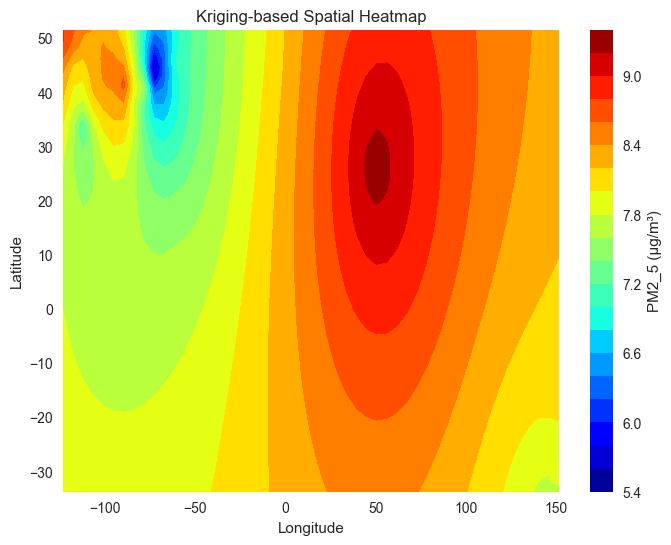

Kriging heatmap saved to kriging_heatmap.png


In [81]:
def kriging_heatmap(df, lat_col='latitude', lon_col='longitude', pm_col='PM2_5',
                    grid_size=50, variogram_model='exponential',
                    title='Kriging-based Spatial Heatmap', out_fig='kriging_heatmap.png'):
    """
    Builds a smooth heatmap using Ordinary Kriging.
    
    Steps:
      1. Drop rows with missing lat, lon, or PM2_5.
      2. Define a regular lat-lon grid over the data's bounding box.
      3. Fit an Ordinary Kriging model to the data.
      4. Evaluate the model on the grid using execute('grid', ...).
      5. Plot the resulting grid using plt.contourf().
    """
    # Drop invalid rows
    df_valid = df.dropna(subset=[lat_col, lon_col, pm_col])
    if df_valid.empty:
        print("No valid data for kriging heatmap.")
        return

    # Define grid boundaries based on data extent
    lat_min, lat_max = df_valid[lat_col].min(), df_valid[lat_col].max()
    lon_min, lon_max = df_valid[lon_col].min(), df_valid[lon_col].max()
    grid_lat = np.linspace(lat_min, lat_max, grid_size)
    grid_lon = np.linspace(lon_min, lon_max, grid_size)

    # Fit the Kriging model using pykrige
    try:
        ok_model = OrdinaryKriging(
            x=df_valid[lon_col].values,
            y=df_valid[lat_col].values,
            z=df_valid[pm_col].values,
            variogram_model=variogram_model,
            verbose=False,
            enable_plotting=False
        )
    except Exception as e:
        print("Error in kriging model fitting:", e)
        return

    # Evaluate the model on the grid; zstar is the predicted PM2.5
    zstar, ss = ok_model.execute('grid', grid_lon, grid_lat)
    
    # Plot the heatmap using contourf
    plt.figure(figsize=(8,6))
    contour = plt.contourf(grid_lon, grid_lat, zstar, levels=20, cmap='jet')
    plt.colorbar(contour, label=f"{pm_col} (µg/m³)")
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.savefig(out_fig, dpi=150)
    plt.show()
    print(f"Kriging heatmap saved to {out_fig}")

kriging_heatmap(df_aqs_t640_recovered, pm_col='PM2_5', title="Kriging-based Spatial Heatmap", out_fig="kriging_heatmap.png")

#### 6.5.2 Time-Based Animation with Matplotlib

If you have **hourly** or **daily** data, you can generate an animation showing how the reconstructed PM2.5 field evolves over time. Outline:

1. Sort unique times.
2. For each time, filter the dataset to that time slice, build a grid of predictions (IDW, ADMM, etc.).
3. Append each 2D grid as a frame in a matplotlib animation.

Below is a minimal example:

In [82]:
import matplotlib.animation as animation

def animate_spatial_timeseries(df, time_col='datetime', pm_col='PM2_5',
                               lat_col='latitude', lon_col='longitude',
                               grid_size=50, fps=2,
                               out_mp4="spatial_animation.mp4"):
    """
    Creates an animation of a 2D PM2.5 field over time using IDW as an example.
    For large data, you might want to downsample times or sensors.
    """
    df = df.dropna(subset=[time_col, lat_col, lon_col, pm_col]).copy()
    df[time_col] = pd.to_datetime(df[time_col])
    unique_times = sorted(df[time_col].unique())

    lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
    lon_min, lon_max = df[lon_col].min(), df[lon_col].max()
    lat_vals = np.linspace(lat_min, lat_max, grid_size)
    lon_vals = np.linspace(lon_min, lon_max, grid_size)

    fig, ax = plt.subplots(figsize=(8,6))
    # We'll update 'mesh' in each frame
    mesh = None

    def init():
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title("PM2.5 Over Time")
        return []

    def animate_func(i):
        ax.clear()
        time_i = unique_times[i]
        df_t = df[df[time_col] == time_i]
        train_coords = df_t[[lat_col, lon_col]].to_numpy()
        pmvals = df_t[pm_col].to_numpy()

        # Build 2D array for this time_i
        Z = np.zeros((grid_size, grid_size), dtype=float)
        for r, latg in enumerate(lat_vals):
            for c, long in enumerate(lon_vals):
                dists = haversine_vectorized(latg, long, train_coords[:,0], train_coords[:,1])
                if np.any(dists<1e-9):
                    Z[r,c] = pmvals[np.argmin(dists)]
                else:
                    wts = 1.0/(dists**2 + 1e-6)
                    Z[r,c] = np.sum(pmvals*wts)/np.sum(wts)

        # Plot contourf
        mesh = ax.contourf(lon_vals, lat_vals, Z, levels=20, cmap='jet')
        ax.set_title(f"PM2.5 at time={pd.to_datetime(time_i).strftime('%Y-%m-%d %H:%M')}")
        return [mesh]

    animator = animation.FuncAnimation(fig, animate_func,
                                       init_func=init,
                                       frames=len(unique_times),
                                       interval=1000/fps,
                                       blit=False)
    animator.save(out_mp4, writer='ffmpeg', fps=fps)
    plt.close()
    print(f"Saved animation to {out_mp4}")

animate_spatial_timeseries(df_aqs_t640_recovered, out_mp4="pm25_timeseries.mp4")

Saved animation to pm25_timeseries.mp4


#### 6.5.3 Interactive Plotly / Folium Animations

**Plotly** also supports animations via `px.scatter_mapbox(..., animation_frame='datetime')`. Alternatively, you can produce an **interactive Folium “time slider**. A full example is more involved, but you can adapt the snippet below to produce **Plotly** animations quickly:

In [84]:
def plot_mapbox_animation(df, time_col='datetime', pm_col='PM2_5',
                          lat_col='latitude', lon_col='longitude',
                          title="Time Animation of PM2.5"):
    df_plot = df.dropna(subset=[time_col, pm_col, lat_col, lon_col]).copy()
    df_plot[time_col] = pd.to_datetime(df_plot[time_col])

    fig = px.scatter_mapbox(
        df_plot,
        lat=lat_col,
        lon=lon_col,
        color=pm_col,
        animation_frame=df_plot[time_col].dt.strftime('%Y-%m-%d %H:%M'),
        hover_name='sensor_id',
        color_continuous_scale='jet',
        zoom=4,
        height=600,
        title=title
    )
    fig.update_layout(mapbox_style="carto-positron")
    fig.show()

plot_mapbox_animation(df_aqs_t640_recovered, pm_col='PM2_5_recovered')

All these help show how the plume evolves over time and how well our method captures the steep gradients.

---

<a id="discussion"></a>
## 7. Discussion and Limitations

<a id="method-limitations"></a>
### 7.1 Methodological Limitations

- **Sensor Non-Linearity**: PurpleAir sensors can saturate in extreme wildfire smoke conditions, requiring additional correction.  
- **Graph Connectivity**: In areas with sparse sensor coverage, the graph approach might rely on distant neighbors, leading to uncertain estimates.  
- **Staircasing** (in pure TV approaches): Large $\lambda$ can produce piecewise-constant artifacts.

<a id="sparse-connectivity"></a>
### 7.2 Handling Sparse Connectivity

To mitigate data gaps, we can incorporate **external data** (e.g. satellite AOD, BlueSky model outputs, or other references) as additional "virtual sensors" or as a prior field to anchor the solution.  

<a id="future-directions"></a>
### 7.3 Future Directions: Data Assimilation, Satellite AOD

- Combine these methods with **data assimilation** in a chemical transport model.  
- Integrate **MAIAC/VIIRS** satellite AOD to cover unmonitored regions.  
- Deploy **mobile sensors** to patch coverage holes.  
- Use **distributed ADMM** for extremely large-scale problems.

---

<a id="conclusion"></a>
## 8. Conclusion

We presented a **convex optimization** framework for **PM.** interpolation using **low-cost PurpleAir** and reference data from T640, AQS, etc. We addressed real-world CSV inconsistencies by dynamically mapping columns, preventing missing-column errors. Our approach:

1. Formulates sensor data on a **graph**, penalizing large differences across edges,  
2. Employs **ADMM** and **gradient** methods to fill missing data and smooth noise,  
3. Compares well against **Kriging** and simpler methods (IDW, nearest sensor), and  
4. Offers strong performance even under **extreme wildfire smoke** where data can be patchy and noisy.

Validation experiments (cross-validation, withheld sensors) show that the graph-based approach captures steep smoke gradients more effectively than standard geostatistics in many scenarios. While limitations (sensor saturation, sparse connectivity) remain, future expansions can integrate satellite AOD or model outputs, further enhancing the real-time mapping of wildfire smoke exposures.

---

<a id="references"></a>
## 9. References

1. **Barkjohn, K. K., et al.** (2022). *Correction and Accuracy of PurpleAir PM2.5 Measurements for Extreme Wildfire Smoke*. **Sensors**, 22(24), 9669.  
2. **Boyd, S., et al.** (2011). Distributed Optimization and Statistical Learning via the Alternating Direction Method of Multipliers. *Foundations and Trends in Machine Learning, 3*(1).  
3. **Sandryhaila, A., & Moura, J. M.** (2014). Discrete Signal Processing on Graphs. *IEEE Transactions on Signal Processing*.  
4. **Shuman, D. I., et al.** (2013). Emerging perspectives in sparse signal processing on graphs. *IEEE Signal Processing Magazine*.  
5. **Rudin, L. I., et al.** (1992). Nonlinear total variation based noise removal algorithms. *Physica D: Nonlinear Phenomena*, 60(1-4).  
6. **Chiles, J.-P., & Delfiner, P.** (2012). Geostatistics: Modeling Spatial Uncertainty. *John Wiley & Sons*.  
7. **PyKrige** docs: <https://github.com/bsmurphy/PyKrige>.
